# MultiVelo Fig2

We will use the embryonic E18 mouse brain from 10X Multiome as an example.

CellRanger output files can be downloaded from [10X website](https://www.10xgenomics.com/resources/datasets/fresh-embryonic-e-18-mouse-brain-5-k-1-standard-1-0-0). Crucially, the filtered feature barcode matrix folder, ATAC peak annotations TSV, and the feature linkage BEDPE file in the secondary analysis outputs folder will be needed in this demo. 

Quantified unspliced and spliced counts from Velocyto can be downloaded from [MultiVelo GitHub page](https://github.com/welch-lab/MultiVelo).

We provide the cell annotations for this dataset in "cell_annotations.tsv" on the GitHub page. (To download from GitHub, click on the file, then click "Raw" on the top right corner. If it opens in your browser, you can download the page as a text file.)

Weighted nearest neighbors from Seurat can be downloaded from GitHub folder "seurat_wnn", which contains a zip file of three files: "nn_cells.txt", "nn_dist.txt", and "nn_idx.txt". Please unzip the archive after downloading. The R script used to generate such files can also be found in the same folder.
```
.
|-- MultiVelo_Fig2.ipynb
|-- cell_annotations.tsv
|-- outs
|   |-- analysis
|   |   `-- feature_linkage
|   |       `-- feature_linkage.bedpe
|   |-- filtered_feature_bc_matrix
|   |   |-- barcodes.tsv.gz
|   |   |-- features.tsv.gz
|   |   `-- matrix.mtx.gz
|   `-- peak_annotation.tsv
|-- seurat_wnn
|   |-- nn_cells.txt
|   |-- nn_dist.txt
|   `-- nn_idx.txt
`-- velocyto
    `-- 10X_multiome_mouse_brain.loom
```

In [1]:
%load_ext autoreload
%autoreload 2

import os
import scipy
import numpy as np
import pandas as pd
import sys
import multivelo as mv
import scanpy as sc
import scvelo as scv
import matplotlib.pyplot as plt

sys.path.append("/..")

/Users/jake/opt/anaconda3/lib/python3.9/site-packages/umap_learn-0.5.3-py3.9.egg/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/umap_learn-0.5.3-py3.9.egg/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/jake/opt/anaconda3/lib/python

In [ ]:
import time

mv.settings.LOG_FILENAME = "Fig2_" + str(time.time()) + ".txt"

In [2]:
scv.settings.verbosity = 3
scv.settings.presenter_view = True
scv.set_figure_params('scvelo')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)
np.set_printoptions(suppress=True)

## Reading in unspliced and spliced counts

In [3]:
adata_rna = scv.read("velocyto/10X_multiome_mouse_brain.loom", cache=True)
adata_rna.obs_names = [x.split(':')[1][:-1] + '-1' for x in adata_rna.obs_names]
adata_rna.var_names_make_unique()

In [4]:
sc.pp.filter_cells(adata_rna, min_counts=1000)
sc.pp.filter_cells(adata_rna, max_counts=20000)

In [5]:
# Top 1000 variable genes are used for downstream analyses.
scv.pp.filter_and_normalize(adata_rna, min_shared_counts=10, n_top_genes=1000)

Filtered out 21580 genes that are detected 10 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 1000 highly variable genes.
Logarithmized X.


In [6]:
# Load cell annotations
cell_annot = pd.read_csv('cell_annotations.tsv', sep='\t', index_col=0)

In [7]:
adata_rna = adata_rna[cell_annot.index,:]
adata_rna.obs['celltype'] = cell_annot['celltype']

In [8]:
# We subset for lineages towards neurons and astrocytes.
adata_rna = adata_rna[adata_rna.obs['celltype'].isin(['RG, Astro, OPC', 
                                                      'IPC', 
                                                      'V-SVZ', 
                                                      'Upper Layer', 
                                                      'Deeper Layer', 
                                                      'Ependymal cells', 
                                                      'Subplate'])]
adata_rna

View of AnnData object with n_obs × n_vars = 3653 × 1000
    obs: 'n_counts', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'celltype'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

## Preprocessing the ATAC counts

In [9]:
adata_atac = sc.read_10x_mtx('outs/filtered_feature_bc_matrix/', var_names='gene_symbols', cache=True, gex_only=False)
adata_atac = adata_atac[:,adata_atac.var['feature_types'] == "Peaks"]

In [10]:
# We aggregate peaks around each gene as well as those that have high correlations with promoter peak or gene expression.
# Peak annotation contains the metadata for all peaks.
# Feature linkage contains pairs of correlated genomic features.
adata_atac = mv.aggregate_peaks_10x(adata_atac, 
                                    'outs/peak_annotation.tsv', 
                                    'outs/analysis/feature_linkage/feature_linkage.bedpe')


CellRanger ARC identified as 1.0.0

Found 19006 genes with promoter peaks



/Users/jake/opt/anaconda3/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/19006 [00:00<?, ?it/s]

In [11]:
# Let's examine the total count distribution and remove outliers.
# plt.hist(adata_atac.X.sum(1), bins=100, range=(0, 100000));

In [12]:
sc.pp.filter_cells(adata_atac, min_counts=2000)
sc.pp.filter_cells(adata_atac, max_counts=60000)

In [13]:
# We normalize aggregated peaks with TF-IDF.
mv.tfidf_norm(adata_atac)

## Finding shared barcodes and features between RNA and ATAC

In [14]:
shared_cells = pd.Index(np.intersect1d(adata_rna.obs_names, adata_atac.obs_names))
shared_genes = pd.Index(np.intersect1d(adata_rna.var_names, adata_atac.var_names))
len(shared_cells), len(shared_genes)

(3365, 936)

In [15]:
# We reload in the raw data and continue with a subset of cells.
adata_rna = scv.read("velocyto/10X_multiome_mouse_brain.loom", cache=True)
adata_rna.obs_names = [x.split(':')[1][:-1] + '-1' for x in adata_rna.obs_names]
adata_rna.var_names_make_unique()

In [16]:
adata_rna = adata_rna[shared_cells, shared_genes]
adata_atac = adata_atac[shared_cells, shared_genes]

In [17]:
scv.pp.normalize_per_cell(adata_rna)
scv.pp.log1p(adata_rna)
scv.pp.moments(adata_rna, n_pcs=30, n_neighbors=50)

Normalized count data: X, spliced, unspliced.
computing neighbors


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [18]:
adata_rna.obs['celltype'] = cell_annot.loc[adata_rna.obs_names, 'celltype']
adata_rna.obs['celltype'] = adata_rna.obs['celltype'].astype('category')

In [19]:
# Reorder the categories for color consistency with the manuscript.
all_clusters = ['Upper Layer',
                'Deeper Layer',
                'V-SVZ',
                'RG, Astro, OPC',
                'Ependymal cells',
                'IPC',
                'Subplate']
adata_rna.obs['celltype'] = adata_rna.obs['celltype'].cat.reorder_categories(all_clusters)

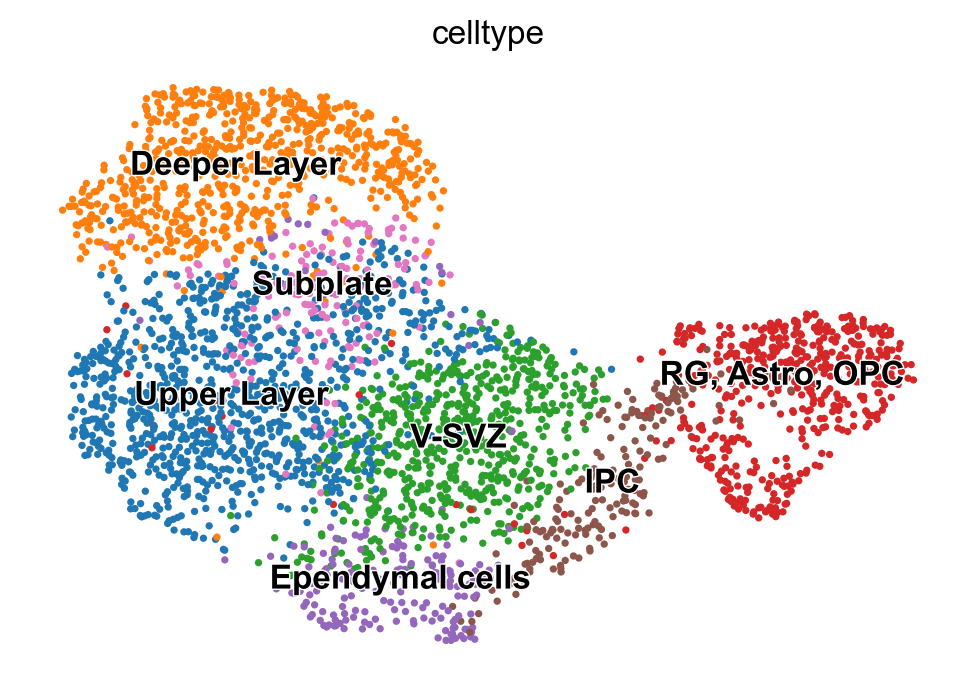

In [20]:
scv.tl.umap(adata_rna)
scv.pl.umap(adata_rna, color='celltype')

## Smoothing gene aggregagted peaks by neighbors

In [21]:
# Write out filtered cells and prepare to run Seurat WNN --> R script can be found on Github.
adata_rna.obs_names.to_frame().to_csv('filtered_cells.txt', header=False, index=False)

In [22]:
# Read in Seurat WNN neighbors.
nn_idx = np.loadtxt("seurat_wnn/nn_idx.txt", delimiter=',')
nn_dist = np.loadtxt("seurat_wnn/nn_dist.txt", delimiter=',')
nn_cells = pd.Index(pd.read_csv("seurat_wnn/nn_cells.txt", header=None)[0])

# Make sure cell names match.
np.all(nn_cells == adata_atac.obs_names)

True

In [23]:
mv.knn_smooth_chrom(adata_atac, nn_idx, nn_dist)

## Running multi-omic dynamical model

MultiVelo incorporates chromatin accessibility information into RNA velocity and achieves better lineage predictions.

The detailed argument list can be shown with "help(mv.recover_dynamics_chrom)".

recovering dynamics (using 1/10 cores)


/Users/jake/opt/anaconda3/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/850 [00:00<?, ?gene/s]

    finished (0:04:22) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/10 cores)


/Users/jake/opt/anaconda3/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/3365 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


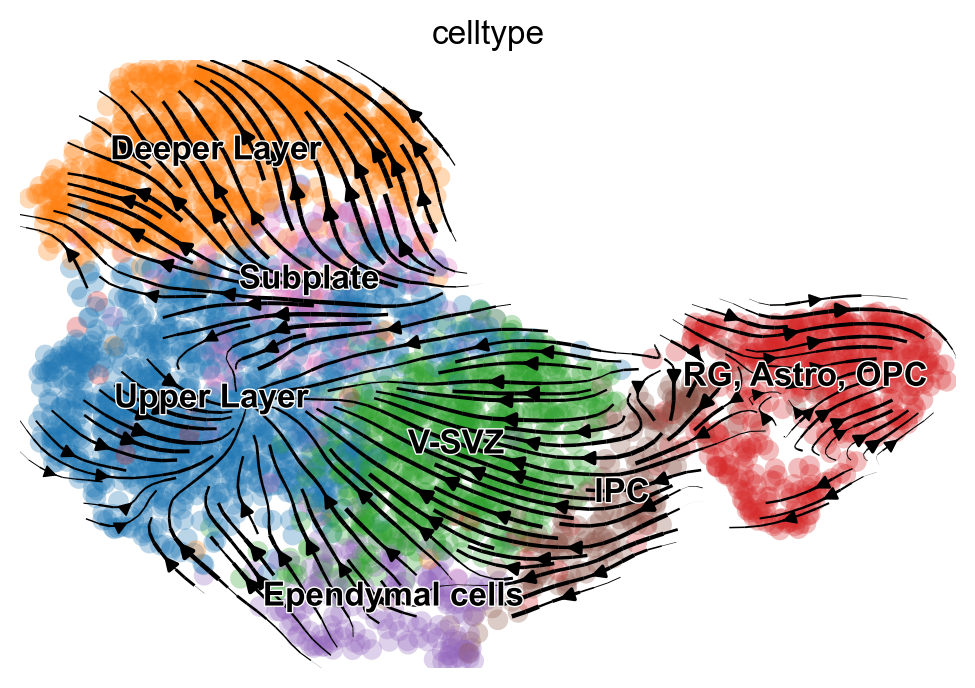

In [24]:
scv.tl.recover_dynamics(adata_rna)
scv.tl.velocity(adata_rna, mode="dynamical")
scv.tl.velocity_graph(adata_rna, n_jobs=1)
scv.tl.latent_time(adata_rna)
scv.pl.velocity_embedding_stream(adata_rna, basis='umap', color='celltype')

In [25]:
# This will take a while. Parallelization is high recommended.

adata_result = mv.recover_dynamics_chrom(adata_rna, 
                                        adata_atac,
                                        max_iter=5, 
                                        init_mode="invert",
                                        parallel=True,
                                        n_jobs = 10,
                                        save_plot=False,
                                        rna_only=False,
                                        fit=True,
                                        n_anchors=500, 
                                        extra_color_key='celltype'
                                        )


936 genes will be fitted

running 10 jobs in parallel



/Users/jake/opt/anaconda3/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/936 [00:00<?, ?it/s]

/Users/jake/opt/anaconda3/lib/python3.9/site-packages/umap_learn-0.5.3-py3.9.egg/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/umap_learn-0.5.3-py3.9.egg/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/jake/opt/anaconda3/lib/python

/Users/jake/opt/anaconda3/lib/python3.9/site-packages/umap_learn-0.5.3-py3.9.egg/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/umap_learn-0.5.3-py3.9.egg/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/jake/opt/anaconda3/lib/python

3110099E03Rik - predicted partial trajectory: False

3110099E03Rik - predicted trajectory direction:complete

3110099E03Rik - predicted model: 1

3110099E03Rik - initial params:
switch time array = [1.         2.         6.17459192],
rates = [0.07791529 1.08831146 1.         0.96031377],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.8536741698426007

3110099E03Rik - initial loss: 0.013266004364879218

3110099E03Rik - removing gaps and realigning by 1.9452602141120237..

3110099E03Rik - computing likelihood..

3110099E03Rik - likelihood of c: 0.23278672614825313, likelihood of u: 0.40505170920955, likelihood of s: 0.26238160750620204

3110099E03Rik - computing velocities..

3110099E03Rik - fitted params:
switch time array = [2.15150817 4.55027257 8.18168181],
rates = [0.01966576 0.56121666 0.4594501  0.52529418],
cc scale = 0.802912171010864,
c rescale factor = 1.2015818441247093,
u rescale factor = 0.9408200746806998

3110099E03Rik - aligning to range (0,20) by 1.0..

31

2810403D21Rik - predicted partial trajectory: True

2810403D21Rik - predicted trajectory direction:on

2810403D21Rik - predicted model: 1

2810403D21Rik - initial params:
switch time array = [1. 2. 4.],
rates = [0.18444289 1.24303073 1.         0.72880834],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.43407375404994103

2810403D21Rik - initial loss: 0.02043208518768942

2810403D21Rik - removing gaps and realigning by 5.084161235244609..

2810403D21Rik - computing likelihood..

2810403D21Rik - likelihood of c: 0.25782298343740195, likelihood of u: 0.14796672067719796, likelihood of s: 0.5694752831814438

2810403D21Rik - computing velocities..

2810403D21Rik - fitted params:
switch time array = [ 8.55823459 18.96911847 20.        ],
rates = [0.02116037 0.25949286 0.24598592 0.1431843 ],
cc scale = 0.4220407229847427,
c rescale factor = 1.0534544000192634,
u rescale factor = 0.36755760491927436

2810403D21Rik - aligning to range (0,20) by 1.0549682875264272..

2810403D21Ri

6720427I07Rik - predicted partial trajectory: False

6720427I07Rik - predicted trajectory direction:complete

6720427I07Rik - predicted model: 1

6720427I07Rik - initial params:
switch time array = [ 5.          6.         11.90775528],
rates = [0.08453114 1.18254277 1.         1.07235481],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.7697201891088804

6720427I07Rik - initial loss: 0.006653048571514639

6720427I07Rik - removing gaps and realigning by 1.1489844040815436..

6720427I07Rik - computing likelihood..

6720427I07Rik - likelihood of c: 0.27395202881828773, likelihood of u: 0.3200000601986937, likelihood of s: 0.3844382120399096

6720427I07Rik - computing velocities..

6720427I07Rik - fitted params:
switch time array = [ 8.20422249 11.05084364 13.94633182],
rates = [0.04749184 1.00399506 0.60732107 0.9548478 ],
cc scale = 2.6618674875164254,
c rescale factor = 0.9655196199730147,
u rescale factor = 0.6444472764832273

6720427I07Rik - aligning to range (0,20) by 1

9530059O14Rik - predicted partial trajectory: True

9530059O14Rik - predicted trajectory direction:on

9530059O14Rik - predicted model: 1

9530059O14Rik - initial params:
switch time array = [3.         6.         9.90775528],
rates = [0.09309231 1.13546511 1.         1.3545138 ],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.6250027417730375

9530059O14Rik - initial loss: 0.0030596442087049884

9530059O14Rik - removing gaps and realigning by 1.5269568257869006..

9530059O14Rik - computing likelihood..

9530059O14Rik - likelihood of c: 0.21779432673247842, likelihood of u: 0.32889064988221384, likelihood of s: 0.5105547492025752

9530059O14Rik - computing velocities..

9530059O14Rik - fitted params:
switch time array = [ 2.58790091 10.46666263 20.        ],
rates = [0.10893844 0.80065368 0.44418551 0.73333045],
cc scale = 0.9449694192306635,
c rescale factor = 1.0423425509654418,
u rescale factor = 0.41033417011628925

9530059O14Rik - aligning to range (0,20) by 1.911877

9430041J12Rik - predicted partial trajectory: True

9430041J12Rik - predicted trajectory direction:on

9430041J12Rik - predicted model: 1

9430041J12Rik - initial params:
switch time array = [1.         4.         6.77431518],
rates = [0.26342373 0.18610593 1.         0.98286549],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.8526341438964071

9430041J12Rik - initial loss: 0.00016525192276599019

9430041J12Rik - removing gaps and realigning by 3.2485337126238516..

9430041J12Rik - computing likelihood..

9430041J12Rik - likelihood of c: 0.20739157351905754, likelihood of u: 0.2773560671222518, likelihood of s: 0.5043070264763256

9430041J12Rik - computing velocities..

9430041J12Rik - fitted params:
switch time array = [ 5.55639169 19.32224869 20.        ],
rates = [0.07831556 0.05892973 0.71163283 0.2444072 ],
cc scale = 1.0628099656729388,
c rescale factor = 0.890472342379339,
u rescale factor = 1.7679960490643039

9430041J12Rik - aligning to range (0,20) by 1.04175365

Cdca8 - fitted params:
switch time array = [1.19060511 4.80753941 8.84450125],
rates = [ 0.0314336  20.58835418  1.15440499  1.42299441],
cc scale = 1.0486307761265494,
c rescale factor = 1.0516715702908526,
u rescale factor = 0.724082403800927

Cdca8 - aligning to range (0,20) by 1.0639658848614073..

Cdca8 - final params:
switch time array = [-0.01255447  3.83574023  8.1309299 ],
rates = [ 0.0295438  19.35057738  1.08500189  1.33744364],
cc scale = 1.0486307761265494,
c rescale factor = 1.0516715702908526,
u rescale factor = 0.724082403800927

Cdca8 - final loss: 0.01760875214329295

Cdca8 - final likelihood: 0.06541616103446858

Cdh6 - predicted partial trajectory: True

Cdh6 - predicted trajectory direction:on

Cdh6 - predicted model: 1

Cdh6 - initial params:
switch time array = [3.         6.         9.90775528],
rates = [0.07095691 4.05914384 1.         1.79464114],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.5029925725413247

Cdh6 - initial loss: 0.014744525650

Cd47 - final params:
switch time array = [-0.02432704  4.75592609 22.99646905],
rates = [0.11618201 4.49198641 1.19860711 1.2154371 ],
cc scale = 0.9368944416761007,
c rescale factor = 1.3431136434793403,
u rescale factor = 0.827739479751477

Cd47 - final loss: 0.0816455358121046

Cd47 - final likelihood: 0.08270834857472112

Cdca2 - predicted partial trajectory: True

Cdca2 - predicted trajectory direction:on

Cdca2 - predicted model: 1

Cdca2 - initial params:
switch time array = [ 5.          6.         11.90775528],
rates = [0.08903596 3.82412409 1.         2.1412691 ],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.4478783240165376

Cdca2 - initial loss: 0.005410428658013552

Cdca2 - removing gaps and realigning by 3.344095589402277..

Cdca2 - computing likelihood..

Cdca2 - likelihood of c: 0.070627355979535, likelihood of u: 0.4587575929001305, likelihood of s: 0.5763262422805706

Cdca2 - computing velocities..

Cdca2 - fitted params:
switch time array = [13.671682

Cfap44 - predicted trajectory direction:on

Cfap44 - predicted model: 1

Cfap44 - initial params:
switch time array = [3.         6.         9.90775528],
rates = [0.05498743 0.25970173 1.         1.09009762],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.7277733441036285

Cfap44 - initial loss: 5.277707170425484e-05

Cfap44 - removing gaps and realigning by 2.8990884174106633..

Cfap44 - computing likelihood..

Cfap44 - likelihood of c: 0.11724385036547852, likelihood of u: 0.24138020269138366, likelihood of s: 0.5151109950308264

Cfap44 - computing velocities..

Cfap44 - fitted params:
switch time array = [13.93902526 19.41112843 20.        ],
rates = [0.02201869 0.09872466 0.75843781 0.3165629 ],
cc scale = 0.9889598231193804,
c rescale factor = 0.9823740155695346,
u rescale factor = 1.0922267898482274

Cfap44 - aligning to range (0,20) by 1.03099173553719..

Cfap44 - final params:
switch time array = [14.37101985 20.01271299 20.61983471],
rates = [0.0213568  0.0957569

Cdca7l - final params:
switch time array = [14.59326732 20.01757617 20.83507307],
rates = [0.02000658 0.11960899 2.13984094 0.22330823],
cc scale = 0.274546706351727,
c rescale factor = 0.9061387390424211,
u rescale factor = 3.0

Cdca7l - final loss: 0.00031138468162797726

Cdca7l - final likelihood: 0.024119648753734242

Cdk6 - predicted partial trajectory: False

Cdk6 - predicted trajectory direction:complete

Cdk6 - predicted model: 1

Cdk6 - initial params:
switch time array = [3.         6.         9.90775528],
rates = [0.1573044  4.86771721 1.         1.87744846],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.5035343855732755

Cdk6 - initial loss: 0.02009599844724404

Cdk6 - removing gaps and realigning by 1.2957198383528474..

Cdk6 - computing likelihood..

Cdk6 - likelihood of c: 0.33776625643229874, likelihood of u: 0.8403606532654216, likelihood of s: 0.8121930261516194

Cdk6 - computing velocities..

Cdk6 - fitted params:
switch time array = [ 3.86308213  8.56

Cdkn1c - final loss: 0.04161449447904616

Cdkn1c - final likelihood: 0.05244229445634094

Cenpe - predicted partial trajectory: False

Cenpe - predicted trajectory direction:complete

Cenpe - predicted model: 2

Cenpe - initial params:
switch time array = [1.         7.90775528 8.90775528],
rates = [ 0.04445576 12.4366796   1.          1.72156855],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.5438543397220625

Cenpe - initial loss: 0.07506482952476222

Cenpe - removing gaps and realigning by 1.0057476944234307..

Cenpe - computing likelihood..

Cenpe - likelihood of c: 0.2052322178309126, likelihood of u: 0.3942457477380339, likelihood of s: 0.4314205327204131

Cenpe - computing velocities..

Cenpe - fitted params:
switch time array = [2.30324287 6.72814787 6.93028479],
rates = [ 0.08213295 13.79241202  2.14199951  2.05542524],
cc scale = 1.114109893086523,
c rescale factor = 0.9154617415453585,
u rescale factor = 1.07954307127995

Cenpe - aligning to range (0,20) by 1.

Cfap97d2 - final params:
switch time array = [ 8.18242605 20.01145733 21.6017316 ],
rates = [0.01325528 0.09100844 0.35923335 0.17423663],
cc scale = 0.9619917783356271,
c rescale factor = 1.2991131959684892,
u rescale factor = 1.1181603846329073

Cfap97d2 - final loss: 9.648821145273168e-05

Cfap97d2 - final likelihood: 0.023594022534844876

Cks2 - predicted partial trajectory: True

Cks2 - predicted trajectory direction:on

Cks2 - predicted model: 1

Cks2 - initial params:
switch time array = [3.         6.         9.90775528],
rates = [0.06786458 6.73975714 1.         1.57508199],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.5591134850009882

Cks2 - initial loss: 0.0533155018078039

Cks2 - removing gaps and realigning by 2.750548602637461..

Cks2 - computing likelihood..

Cks2 - likelihood of c: 0.1852853758099857, likelihood of u: 0.2960655376842989, likelihood of s: 0.4817785493474901

Cks2 - computing velocities..

Cks2 - fitted params:
switch time array = [11.908

Ccdc141 - final params:
switch time array = [-8.41260797e-03  2.00425320e+01  2.13882863e+01],
rates = [0.08935058 0.45655079 0.40853468 1.66301221],
cc scale = 0.9662449077606685,
c rescale factor = 1.0004008669730382,
u rescale factor = 0.2

Ccdc141 - final loss: 0.00034622005792414134

Ccdc141 - final likelihood: 0.002470342802055614

Cdca3 - predicted partial trajectory: False

Cdca3 - predicted trajectory direction:complete

Cdca3 - predicted model: 2

Cdca3 - initial params:
switch time array = [3.         6.56967977 9.56967977],
rates = [0.07317644 2.05044918 1.         0.71404509],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.9284690653532449

Cdca3 - initial loss: 0.026738584339922523

Cdca3 - removing gaps and realigning by 1.2088778785934953..

Cdca3 - computing likelihood..

Cdca3 - likelihood of c: 0.10947971188603782, likelihood of u: 0.4013777126207532, likelihood of s: 0.35909770350638076

Cdca3 - computing velocities..

Cdca3 - fitted params:
switch tim

Eif1b - fitted params:
switch time array = [ 1.45226222 10.4414772  10.71098335],
rates = [ 0.04320117 14.16783883  0.64128954  1.04771816],
cc scale = 1.1157064776777692,
c rescale factor = 0.989911096789809,
u rescale factor = 0.663299623104177

Eif1b - aligning to range (0,20) by 1.0..

Eif1b - final params:
switch time array = [ 1.45226222 10.4414772  10.71098335],
rates = [ 0.04320117 14.16783883  0.64128954  1.04771816],
cc scale = 1.1157064776777692,
c rescale factor = 0.989911096789809,
u rescale factor = 0.663299623104177

Eif1b - final loss: 1.3817698349493062

Eif1b - final likelihood: 0.07807437433692326

Enc1 - predicted partial trajectory: False

Enc1 - predicted trajectory direction:complete

Enc1 - predicted model: 1

Enc1 - initial params:
switch time array = [3.         6.         9.90775528],
rates = [ 0.11245968 10.00803901  1.          1.08068893],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.7933573235336925

Enc1 - initial loss: 0.9039429825862485

Elk3 - fitted params:
switch time array = [ 3.35696806  8.44097551 11.21006115],
rates = [0.09800463 0.63744015 0.89364286 1.35492912],
cc scale = 0.9319165456513513,
c rescale factor = 1.0327165756640901,
u rescale factor = 0.6751334262407616

Elk3 - aligning to range (0,20) by 1.0..

Elk3 - final params:
switch time array = [ 3.35696806  8.44097551 11.21006115],
rates = [0.09800463 0.63744015 0.89364286 1.35492912],
cc scale = 0.9319165456513513,
c rescale factor = 1.0327165756640901,
u rescale factor = 0.6751334262407616

Elk3 - final loss: 0.000819209038090144

Elk3 - final likelihood: 0.11570239679677077

Eogt - predicted partial trajectory: True

Eogt - predicted trajectory direction:on

Eogt - predicted model: 1

Eogt - initial params:
switch time array = [3.         6.         9.90775528],
rates = [0.07298843 0.65060246 1.         1.79911637],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.4934128715718264

Eogt - initial loss: 0.0004165067651864439

Eogt - removi

E2f3 - fitted params:
switch time array = [10.67200762 19.40762797 20.        ],
rates = [0.03430563 1.16819372 0.24227653 0.69345776],
cc scale = 0.7923780281494797,
c rescale factor = 0.9601964494796758,
u rescale factor = 0.2673035518277891

E2f3 - aligning to range (0,20) by 1.03099173553719..

E2f3 - final params:
switch time array = [11.00275166 20.00910404 20.61983471],
rates = [0.0332744  1.13307768 0.23499367 0.67261233],
cc scale = 0.7923780281494797,
c rescale factor = 0.9601964494796758,
u rescale factor = 0.2673035518277891

E2f3 - final loss: 0.00468417067920578

E2f3 - final likelihood: 0.06847806448837036

Egfr - predicted partial trajectory: False

Egfr - predicted trajectory direction:complete

Egfr - predicted model: 1

Egfr - initial params:
switch time array = [ 5.          6.         11.90775528],
rates = [0.10891273 1.61227853 1.         1.55786602],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.6036933326318098

Egfr - initial loss: 0.002174865056

Enpp2 - initial params:
switch time array = [ 5.         11.90775528 12.90775528],
rates = [0.02832656 2.90213051 1.         1.57817124],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.5316250447990998

Enpp2 - initial loss: 0.0024560793229748347

Enpp2 - removing gaps and realigning by 1.5568244351100595..

Enpp2 - computing likelihood..

Enpp2 - likelihood of c: 0.020246912130577624, likelihood of u: 0.1530420786058107, likelihood of s: 0.29499026783539745

Enpp2 - computing velocities..

Enpp2 - fitted params:
switch time array = [ 9.18851505 18.452755   20.        ],
rates = [0.01872355 1.88746002 0.65988816 1.0208518 ],
cc scale = 0.8687785779606778,
c rescale factor = 1.5,
u rescale factor = 0.5137388462794193

Enpp2 - aligning to range (0,20) by 1.0847826086956522..

Enpp2 - final params:
switch time array = [ 9.96754132 20.0172277  21.69565217],
rates = [0.01726019 1.7399431  0.60831373 0.94106579],
cc scale = 0.8687785779606778,
c rescale factor = 1.5,
u rescale 

Efcab6 - final params:
switch time array = [ 9.58915832 20.03216144 21.28755365],
rates = [0.00949614 0.11008037 0.70835618 0.10813742],
cc scale = 0.8900618419526352,
c rescale factor = 0.9791839735914516,
u rescale factor = 2.0297262088090218

Efcab6 - final loss: 0.0003146651127608454

Efcab6 - final likelihood: 0.06756197811327339

Emx2 - predicted partial trajectory: False

Emx2 - predicted trajectory direction:complete

Emx2 - predicted model: 1

Emx2 - initial params:
switch time array = [1.         6.         7.90775528],
rates = [0.17477054 1.65078901 1.         1.60621292],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.5693630173545756

Emx2 - initial loss: 0.007488326375312419

Emx2 - removing gaps and realigning by 1.0609467762195173..

Emx2 - computing likelihood..

Emx2 - likelihood of c: 0.30858532668026367, likelihood of u: 0.6089885910481795, likelihood of s: 0.6804048299018417

Emx2 - computing velocities..

Emx2 - fitted params:
switch time array = [1.

Eomes - final params:
switch time array = [ 1.99539836  9.92314711 10.13579551],
rates = [0.11815269 8.30523699 0.9167508  1.36020957],
cc scale = 1.0415927381027448,
c rescale factor = 0.8250426563016322,
u rescale factor = 0.7483101236192544

Eomes - final loss: 0.11830915478199104

Eomes - final likelihood: 0.05876682673595774

Etv4 - predicted partial trajectory: False

Etv4 - predicted trajectory direction:complete

Etv4 - predicted model: 1

Etv4 - initial params:
switch time array = [3.         6.         9.90775528],
rates = [0.13643334 0.47832191 1.         1.23898656],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.7407581998788545

Etv4 - initial loss: 0.0007304016997262638

Etv4 - removing gaps and realigning by 1.3722694727688929..

Etv4 - computing likelihood..

Etv4 - likelihood of c: 0.26792571027795115, likelihood of u: 0.5485275290885793, likelihood of s: 0.3372823243038726

Etv4 - computing velocities..

Etv4 - fitted params:
switch time array = [ 4.675

Erbb4 - aligning to range (0,20) by 1.0639658848614073..

Erbb4 - final params:
switch time array = [-0.02176914  5.56509757  7.74512853],
rates = [0.04311634 0.49622257 0.62051935 1.14234017],
cc scale = 1.2140304105235251,
c rescale factor = 0.9414736541799449,
u rescale factor = 0.6554830370482627

Erbb4 - final loss: 0.0003305852816213949

Erbb4 - final likelihood: 0.032779837251711436

Fanca - predicted partial trajectory: True

Fanca - predicted trajectory direction:on

Fanca - predicted model: 1

Fanca - initial params:
switch time array = [3.         6.         9.90775528],
rates = [0.05311935 0.59842957 1.         1.24966014],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.7242642319686221

Fanca - initial loss: 0.0004344953967332875

Fanca - removing gaps and realigning by 2.5418741994156666..

Fanca - computing likelihood..

Fanca - likelihood of c: 0.23647390868921705, likelihood of u: 0.34563095554780965, likelihood of s: 0.5891696357058189

Fanca - computing

Etv1 - final params:
switch time array = [1.73725481 3.30046487 8.7266771 ],
rates = [0.1140954  2.15382245 0.50240672 1.02570861],
cc scale = 0.955218187272229,
c rescale factor = 1.2039894909951108,
u rescale factor = 0.4440009837679807

Etv1 - final loss: 0.004970009246079495

Etv1 - final likelihood: 0.12366740271034841

Fat1 - predicted partial trajectory: False

Fat1 - predicted trajectory direction:complete

Fat1 - predicted model: 1

Fat1 - initial params:
switch time array = [3.         6.         9.90775528],
rates = [0.15646618 1.31709233 1.         1.4346972 ],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.6702402481210804

Fat1 - initial loss: 0.005429615192394469

Fat1 - removing gaps and realigning by 1.0419934916324534..

Fat1 - computing likelihood..

Fat1 - likelihood of c: 0.3408481667456172, likelihood of u: 0.6788331329374245, likelihood of s: 0.7210250028814387

Fat1 - computing velocities..

Fat1 - fitted params:
switch time array = [ 2.67566006  7

Epas1 - final params:
switch time array = [10.34360235 17.52215744 34.53287197],
rates = [0.03591311 0.93558125 0.49383616 2.83116727],
cc scale = 1.6442454974672898,
c rescale factor = 1.0192537281215195,
u rescale factor = 0.21220583469125787

Epas1 - final loss: 0.0003300616621965127

Epas1 - final likelihood: 0.0028964644103393273

Esco2 - predicted partial trajectory: False

Esco2 - predicted trajectory direction:complete

Esco2 - predicted model: 1

Esco2 - initial params:
switch time array = [3.         4.         9.90775528],
rates = [0.10202847 2.0489329  1.         1.43719266],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.6531455338571197

Esco2 - initial loss: 0.0015597446328643077

Esco2 - removing gaps and realigning by 1.0284765254865884..

Esco2 - computing likelihood..

Esco2 - likelihood of c: 0.17856933231178823, likelihood of u: 0.40341951761852307, likelihood of s: 0.3435876434388423

Esco2 - computing velocities..

Esco2 - fitted params:
switch time

Id4 - removing gaps and realigning by 1.7429478050380531..

Id4 - computing likelihood..

Id4 - likelihood of c: 0.1964465141821642, likelihood of u: 0.4376999426180797, likelihood of s: 0.39404341542806104

Id4 - computing velocities..

Id4 - fitted params:
switch time array = [ 7.33276954 12.22160969 12.57435266],
rates = [0.04751756 2.6779579  0.6070075  0.51850526],
cc scale = 1.0175946736705592,
c rescale factor = 0.9514230735576532,
u rescale factor = 1.0645051025699974

Id4 - aligning to range (0,20) by 1.002008032128514..

Id4 - final params:
switch time array = [ 7.34749398 12.24615108 12.59960237],
rates = [0.04742233 2.67259125 0.60579105 0.51746617],
cc scale = 1.0175946736705592,
c rescale factor = 0.9514230735576532,
u rescale factor = 1.0645051025699974

Id4 - final loss: 0.12274558106255146

Id4 - final likelihood: 0.033881676485542335

Il1r1 - low quality gene Il1r1, skipping

Il1rapl1 - predicted partial trajectory: False

Il1rapl1 - predicted trajectory direction:com

Hs6st2 - fitted params:
switch time array = [ 8.89230032 13.18574593 26.04929474],
rates = [1.29775344e-02 3.63007361e+01 5.97903229e-01 2.03162180e+00],
cc scale = 0.4910701885244749,
c rescale factor = 0.9703793105358158,
u rescale factor = 0.29603539082211283

Hs6st2 - aligning to range (0,20) by 1.0374220374220375..

Hs6st2 - final params:
switch time array = [ 8.47662757 12.93074266 26.27567168],
rates = [1.25094069e-02 3.49912907e+01 5.76335577e-01 1.95833685e+00],
cc scale = 0.4910701885244749,
c rescale factor = 0.9703793105358158,
u rescale factor = 0.29603539082211283

Hs6st2 - final loss: 0.12174254728026013

Hs6st2 - final likelihood: 0.408626439911419

Igfbp5 - predicted partial trajectory: False

Igfbp5 - predicted trajectory direction:complete

Igfbp5 - predicted model: 2

Igfbp5 - initial params:
switch time array = [1.         7.90775528 8.90775528],
rates = [0.04453549 7.61878891 1.         1.44928669],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.6397

Htra1 - computing velocities..

Htra1 - fitted params:
switch time array = [1.22408168 8.06151967 8.26271707],
rates = [0.16456691 3.03092135 0.93270707 1.6664567 ],
cc scale = 1.5005340774306224,
c rescale factor = 0.9247647872787632,
u rescale factor = 0.658676962821291

Htra1 - aligning to range (0,20) by 1.0..

Htra1 - final params:
switch time array = [1.22408168 8.06151967 8.26271707],
rates = [0.16456691 3.03092135 0.93270707 1.6664567 ],
cc scale = 1.5005340774306224,
c rescale factor = 0.9247647872787632,
u rescale factor = 0.658676962821291

Htra1 - final loss: 0.007636974616028907

Htra1 - final likelihood: 0.13825422419666855

Igfbp4 - predicted partial trajectory: True

Igfbp4 - predicted trajectory direction:on

Igfbp4 - predicted model: 1

Igfbp4 - initial params:
switch time array = [1.         2.         4.73893847],
rates = [0.20590294 1.09200359 1.         0.9192902 ],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.5406944867553672

Igfbp4 - initial los

Htr1f - fitted params:
switch time array = [ 4.22689596  4.60939125 11.89550863],
rates = [0.08401768 2.42765845 0.66709903 1.24114597],
cc scale = 1.7977304419954543,
c rescale factor = 1.3557471081532646,
u rescale factor = 0.6711015701460432

Htr1f - aligning to range (0,20) by 1.2860824742268042..

Htr1f - final params:
switch time array = [ 5.43613681  5.9280573  15.29860517],
rates = [0.06532838 1.88763824 0.51870626 0.96505939],
cc scale = 1.7977304419954543,
c rescale factor = 1.3557471081532646,
u rescale factor = 0.6711015701460432

Htr1f - final loss: 0.011027175928669076

Htr1f - final likelihood: 0.07318353306934001

Igfbpl1 - predicted partial trajectory: False

Igfbpl1 - predicted trajectory direction:complete

Igfbpl1 - predicted model: 1

Igfbpl1 - initial params:
switch time array = [3.         6.         9.90775528],
rates = [ 0.18656447 33.99081639  1.          1.46907767],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.658618884209959

Igfbpl1 - initi

Inka2 - fitted params:
switch time array = [10.9472304  18.97182842 20.        ],
rates = [0.02987649 0.09334225 0.61448695 0.10550928],
cc scale = 1.1206123041089948,
c rescale factor = 0.846575353460818,
u rescale factor = 1.1025268436814954

Inka2 - aligning to range (0,20) by 1.0549682875264272..

Inka2 - final params:
switch time array = [11.5489809  20.01467734 21.09936575],
rates = [0.0283198  0.08847873 0.58246959 0.10001181],
cc scale = 1.1206123041089948,
c rescale factor = 0.846575353460818,
u rescale factor = 1.1025268436814954

Inka2 - final loss: 0.0006029391822946423

Inka2 - final likelihood: 0.016317223405376436

Islr - predicted partial trajectory: True

Islr - predicted trajectory direction:on

Islr - predicted model: 1

Islr - initial params:
switch time array = [1. 2. 4.],
rates = [0.10882954 2.3589367  1.         0.85590658],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.22585590170077313

Islr - initial loss: 0.1767058314868359

Islr - removing gap

Igfbp2 - final params:
switch time array = [-0.06153339  7.55367628  8.08410565],
rates = [0.01156881 4.7930251  0.32889528 0.41386192],
cc scale = 1.0355036805756224,
c rescale factor = 0.9903519958827884,
u rescale factor = 0.8082375254764163

Igfbp2 - final loss: 0.3958121556262568

Igfbp2 - final likelihood: 0.05921260179395919

Ikzf2 - predicted partial trajectory: False

Ikzf2 - predicted trajectory direction:complete

Ikzf2 - predicted model: 1

Ikzf2 - initial params:
switch time array = [3.         6.         9.90775528],
rates = [0.06040414 1.65647454 1.         1.49842755],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.5970440690578808

Ikzf2 - initial loss: 0.0035654515382541312

Ikzf2 - removing gaps and realigning by 1.3280408424749082..

Ikzf2 - computing likelihood..

Ikzf2 - likelihood of c: 0.2547930004204688, likelihood of u: 0.5407120667111711, likelihood of s: 0.5488873480140966

Ikzf2 - computing velocities..

Ikzf2 - fitted params:
switch time arra

Itga4 - fitted params:
switch time array = [ 1.90781465  6.48005682 12.49241466],
rates = [0.03602198 0.66841994 0.58613948 0.72006942],
cc scale = 0.9572169141673882,
c rescale factor = 1.1297262075908354,
u rescale factor = 0.7293820674446114

Itga4 - aligning to range (0,20) by 1.0..

Itga4 - final params:
switch time array = [ 1.90781465  6.48005682 12.49241466],
rates = [0.03602198 0.66841994 0.58613948 0.72006942],
cc scale = 0.9572169141673882,
c rescale factor = 1.1297262075908354,
u rescale factor = 0.7293820674446114

Itga4 - final loss: 0.0011169451303607093

Itga4 - final likelihood: 0.02689267080945443

Jag1 - predicted partial trajectory: False

Jag1 - predicted trajectory direction:complete

Jag1 - predicted model: 1

Jag1 - initial params:
switch time array = [3.         6.         9.90775528],
rates = [0.19636548 0.86981069 1.         1.23590377],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.6755497820293381

Jag1 - initial loss: 0.0026196810203427197



Kcnd2 - fitted params:
switch time array = [ 2.06970865  2.32873322 27.65169097],
rates = [0.15626325 0.7986997  0.68746713 1.08747106],
cc scale = 1.8468804037050266,
c rescale factor = 1.1681744022061924,
u rescale factor = 0.721134872981231

Kcnd2 - aligning to range (0,20) by 1.0204498977505114..

Kcnd2 - final params:
switch time array = [ 1.70303603  1.96735762 27.80816727],
rates = [0.15313172 0.7826937  0.67369024 1.06567805],
cc scale = 1.8468804037050266,
c rescale factor = 1.1681744022061924,
u rescale factor = 0.721134872981231

Kcnd2 - final loss: 0.0020159769253296693

Kcnd2 - final likelihood: 0.09652113974363578

Klf10 - predicted partial trajectory: True

Klf10 - predicted trajectory direction:on

Klf10 - predicted model: 1

Klf10 - initial params:
switch time array = [3.         4.         8.59754881],
rates = [0.13227951 0.29959566 1.         0.98402911],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.8782211544223377

Klf10 - initial loss: 0.0011041465

Mob3b - likelihood of c: 0.20368962435590407, likelihood of u: 0.25416715141055013, likelihood of s: 0.4738216266367007

Mob3b - computing velocities..

Mob3b - fitted params:
switch time array = [10.86969385 19.15632141 20.        ],
rates = [0.04533181 0.09210383 0.51585497 0.18898892],
cc scale = 1.0393048639085112,
c rescale factor = 0.8007918500201399,
u rescale factor = 1.179214873925523

Mob3b - aligning to range (0,20) by 1.0461215932914045..

Mob3b - final params:
switch time array = [11.37102145 20.03984148 20.92243187],
rates = [0.04333322 0.08804314 0.49311186 0.18065675],
cc scale = 1.0393048639085112,
c rescale factor = 0.8007918500201399,
u rescale factor = 1.179214873925523

Mob3b - final loss: 0.00018219745060358628

Mob3b - final likelihood: 0.02453031969062334

Myh9 - predicted partial trajectory: False

Myh9 - predicted trajectory direction:complete

Myh9 - predicted model: 1

Myh9 - initial params:
switch time array = [3.         6.         9.90775528],
rates = [0.

Msmo1 - fitted params:
switch time array = [ 4.11727601  6.30380251 14.19058175],
rates = [0.05246742 3.95856834 0.58617026 0.84036576],
cc scale = 0.7402281608242937,
c rescale factor = 1.131761057888517,
u rescale factor = 0.8111516053346657

Msmo1 - aligning to range (0,20) by 1.0395833333333335..

Msmo1 - final params:
switch time array = [ 3.69691818  5.9699947  14.16895894],
rates = [0.05046966 3.80784129 0.56385115 0.80836787],
cc scale = 0.7402281608242937,
c rescale factor = 1.131761057888517,
u rescale factor = 0.8111516053346657

Msmo1 - final loss: 0.07263707745592195

Msmo1 - final likelihood: 0.06562241120951923

Ncam2 - predicted partial trajectory: False

Ncam2 - predicted trajectory direction:complete

Ncam2 - predicted model: 2

Ncam2 - initial params:
switch time array = [ 3.          9.90775528 10.90775528],
rates = [0.05208797 3.63797131 1.         2.25431033],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.45549795329164255

Ncam2 - initial loss: 0.0

Ndnf - removing gaps and realigning by 1.088020169844501..

Ndnf - computing likelihood..

Ndnf - likelihood of c: 0.2556490905437548, likelihood of u: 0.31518800941679975, likelihood of s: 0.34980839332351843

Ndnf - computing velocities..

Ndnf - fitted params:
switch time array = [3.18691694 4.18671376 7.89179557],
rates = [0.07567764 0.5602139  0.80648242 0.84157238],
cc scale = 0.8769117535137898,
c rescale factor = 1.0730604645373727,
u rescale factor = 0.951697233735622

Ndnf - aligning to range (0,20) by 1.0..

Ndnf - final params:
switch time array = [3.18691694 4.18671376 7.89179557],
rates = [0.07567764 0.5602139  0.80648242 0.84157238],
cc scale = 0.8769117535137898,
c rescale factor = 1.0730604645373727,
u rescale factor = 0.951697233735622

Ndnf - final loss: 0.0008217606850183591

Ndnf - final likelihood: 0.02818669559286438

Neto1 - predicted partial trajectory: False

Neto1 - predicted trajectory direction:complete

Neto1 - predicted model: 1

Neto1 - initial params:
s

Nfix - fitted params:
switch time array = [ 0.99023348  7.96287365 10.63682125],
rates = [ 0.16812452 17.07019572  0.44219733  1.12908428],
cc scale = 0.7815635538090088,
c rescale factor = 1.0404810923596428,
u rescale factor = 0.5287079311409995

Nfix - aligning to range (0,20) by 1.0162932790224033..

Nfix - final params:
switch time array = [ 0.68050205  7.76674939 10.48426436],
rates = [ 0.16542914 16.79652525  0.435108    1.11098273],
cc scale = 0.7815635538090088,
c rescale factor = 1.0404810923596428,
u rescale factor = 0.5287079311409995

Nfix - final loss: 1.6478596107377028

Nfix - final likelihood: 0.4809220966431341

Nova1 - predicted partial trajectory: False

Nova1 - predicted trajectory direction:complete

Nova1 - predicted model: 2

Nova1 - initial params:
switch time array = [ 3.          9.90775528 10.90775528],
rates = [0.08873444 1.97579755 1.         1.55353825],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.5787818380482765

Nova1 - initial loss: 0

Nin - fitted params:
switch time array = [ 5.35881406  7.29926969 15.43867493],
rates = [0.09269066 4.36342174 0.59536568 1.68854153],
cc scale = 1.9781380514276428,
c rescale factor = 1.5,
u rescale factor = 0.4065209540851433

Nin - aligning to range (0,20) by 1.0267489711934157..

Nin - final params:
switch time array = [ 5.50215682  7.49451764 15.8516436 ],
rates = [0.09027588 4.24974542 0.57985515 1.64455147],
cc scale = 1.9781380514276428,
c rescale factor = 1.5,
u rescale factor = 0.4065209540851433

Nin - final loss: 0.09255439896728007

Nin - final likelihood: 0.2364367264140002

Npas3 - predicted partial trajectory: False

Npas3 - predicted trajectory direction:complete

Npas3 - predicted model: 1

Npas3 - initial params:
switch time array = [3.         6.         9.90775528],
rates = [0.16610879 1.51536878 1.         2.02029832],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.4829564990526534

Npas3 - initial loss: 0.002821616894757234

Npas3 - removing gaps an

Npas1 - fitted params:
switch time array = [1.64103094 3.23182845 6.22646133],
rates = [0.1784213  0.1008825  0.64338995 0.44428173],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.7516542651685338

Npas1 - aligning to range (0,20) by 1.002008032128514..

Npas1 - final params:
switch time array = [1.60416554 3.19815742 6.19880362],
rates = [0.17806375 0.10068033 0.64210059 0.44339139],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.7516542651685338

Npas1 - final loss: 0.00014401467020048173

Npas1 - final likelihood: 0.01777793887475355

Nr2f1 - predicted partial trajectory: False

Nr2f1 - predicted trajectory direction:complete

Nr2f1 - predicted model: 2

Nr2f1 - initial params:
switch time array = [ 3.          9.90775528 10.90775528],
rates = [ 0.07008934 10.60544469  1.          1.69141191],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.561593822451989

Nr2f1 - initial loss: 0.24045970748500445

Nr2f1 - removing gaps and realigning by 1.

Nhs - final params:
switch time array = [ 5.88050365  6.0880555  14.68232649],
rates = [0.06750825 0.5342557  1.01128852 1.096639  ],
cc scale = 1.1578980126344294,
c rescale factor = 0.964838293687198,
u rescale factor = 0.7748549785595493

Nhs - final loss: 0.00026102738542855587

Nhs - final likelihood: 0.0659534690557612

Notch1 - predicted partial trajectory: False

Notch1 - predicted trajectory direction:complete

Notch1 - predicted model: 2

Notch1 - initial params:
switch time array = [1.         7.90775528 8.90775528],
rates = [0.11046518 5.00108531 1.         1.76900035],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.5454330647462994

Notch1 - initial loss: 0.01899626390947094

Notch1 - removing gaps and realigning by 1.4909125121899829..

Notch1 - computing likelihood..

Notch1 - likelihood of c: 0.42179195800578423, likelihood of u: 0.8116186318825424, likelihood of s: 0.7581695025444709

Notch1 - computing velocities..

Notch1 - fitted params:
switch time ar

Nrn1 - aligning to range (0,20) by 1.0..

Nrn1 - final params:
switch time array = [ 2.63023907  8.40547434 12.43278024],
rates = [0.15602682 8.18626216 0.47704422 1.97964797],
cc scale = 0.6170305888683659,
c rescale factor = 1.0328951891195666,
u rescale factor = 0.22151394081247122

Nrn1 - final loss: 0.05487239544593796

Nrn1 - final likelihood: 0.26484762722585015

Nxph1 - predicted partial trajectory: False

Nxph1 - predicted trajectory direction:complete

Nxph1 - predicted model: 1

Nxph1 - initial params:
switch time array = [3.         4.         7.55605058],
rates = [0.12323337 0.40391743 1.         0.94184024],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.7371307299461821

Nxph1 - initial loss: 0.0007319161122838171

Nxph1 - removing gaps and realigning by 1.3662834220247686..

Nxph1 - computing likelihood..

Nxph1 - likelihood of c: 0.1968151235205248, likelihood of u: 0.22810068030399044, likelihood of s: 0.3276808319308467

Nxph1 - computing velocities..



Rad51ap1 - initial params:
switch time array = [ 3.          9.90775528 14.90775528],
rates = [0.03380292 1.52243363 1.         1.27408144],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.6625451435096607

Rad51ap1 - initial loss: 0.003808128820373135

Rad51ap1 - removing gaps and realigning by 1.329615091937194..

Rad51ap1 - computing likelihood..

Rad51ap1 - likelihood of c: 0.254043876923743, likelihood of u: 0.45747300395991625, likelihood of s: 0.39548964823522426

Rad51ap1 - computing velocities..

Rad51ap1 - fitted params:
switch time array = [10.28383366 14.22331438 16.94662695],
rates = [0.02482416 1.90133045 0.80234475 1.05534626],
cc scale = 1.030726271327727,
c rescale factor = 1.1359665125413227,
u rescale factor = 0.6394572192151395

Rad51ap1 - aligning to range (0,20) by 1.323607427055703..

Rad51ap1 - final params:
switch time array = [12.65685145 17.87117739 21.47577413],
rates = [0.01875492 1.43647611 0.6061803  0.79732573],
cc scale = 1.030726271327727,

Rbms3 - final params:
switch time array = [-0.03600576  8.69316873  8.94289542],
rates = [0.03824826 0.37086508 0.74227129 1.13462325],
cc scale = 1.6446719958162666,
c rescale factor = 0.75,
u rescale factor = 0.858109122582654

Rbms3 - final loss: 0.0005218507005679736

Rbms3 - final likelihood: 0.02783391761927192

Rest - predicted partial trajectory: False

Rest - predicted trajectory direction:complete

Rest - predicted model: 2

Rest - initial params:
switch time array = [1.         5.55536993 6.55536993],
rates = [0.1010905  0.65864944 1.         0.91449813],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.8111202255251774

Rest - initial loss: 0.003313034257825149

Rest - removing gaps and realigning by 1.1161411343043885..

Rest - computing likelihood..

Rest - likelihood of c: 0.2742333750806609, likelihood of u: 0.5856098058261835, likelihood of s: 0.5335259452593992

Rest - computing velocities..

Rest - fitted params:
switch time array = [1.4271185  6.50713325

Ptprz1 - fitted params:
switch time array = [ 1.84252227  6.54555513 14.12605149],
rates = [ 0.12210953 19.83982311  0.57075326  1.54718587],
cc scale = 1.0595860795434087,
c rescale factor = 1.0329341525810491,
u rescale factor = 0.3705912984379829

Ptprz1 - aligning to range (0,20) by 1.0639658848614073..

Ptprz1 - final params:
switch time array = [ 1.87509299  6.87895951 14.94434903],
rates = [ 0.11476827 18.64704818  0.53643943  1.45416868],
cc scale = 1.0595860795434087,
c rescale factor = 1.0329341525810491,
u rescale factor = 0.3705912984379829

Ptprz1 - final loss: 0.8668224827992284

Ptprz1 - final likelihood: 0.266610731674691

Rad54b - predicted partial trajectory: False

Rad54b - predicted trajectory direction:complete

Rad54b - predicted model: 1

Rad54b - initial params:
switch time array = [3.         4.         9.90775528],
rates = [0.0738756  3.56655612 1.         1.59610508],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.5850943825497925

Rad54b - init

Rbms1 - fitted params:
switch time array = [ 1.7349959   3.113997   12.80969803],
rates = [0.08918036 1.18912753 0.61150459 0.94138552],
cc scale = 0.8463885185436388,
c rescale factor = 1.3724887207300647,
u rescale factor = 0.6538711829889843

Rbms1 - aligning to range (0,20) by 1.0060483870967742..

Rbms1 - final params:
switch time array = [ 1.62452209  3.01186392 12.7662083 ],
rates = [0.08864421 1.18197847 0.60782821 0.93572589],
cc scale = 0.8463885185436388,
c rescale factor = 1.3724887207300647,
u rescale factor = 0.6538711829889843

Rbms1 - final loss: 0.0032399958115822054

Rbms1 - final likelihood: 0.03301736863492777

Reln - predicted partial trajectory: True

Reln - predicted trajectory direction:on

Reln - predicted model: 1

Reln - initial params:
switch time array = [1.         2.         4.86085524],
rates = [0.19389359 1.29139563 1.         0.81296735],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.7733050871096989

Reln - initial loss: 0.0107679422430

Rhbdl3 - fitted params:
switch time array = [0.84459964 8.34548389 8.60912974],
rates = [0.16093485 1.13020298 0.71108526 1.43859332],
cc scale = 1.2647857814154522,
c rescale factor = 0.8707537148470359,
u rescale factor = 0.5370489882755219

Rhbdl3 - aligning to range (0,20) by 1.0..

Rhbdl3 - final params:
switch time array = [0.84459964 8.34548389 8.60912974],
rates = [0.16093485 1.13020298 0.71108526 1.43859332],
cc scale = 1.2647857814154522,
c rescale factor = 0.8707537148470359,
u rescale factor = 0.5370489882755219

Rhbdl3 - final loss: 0.002776395806426135

Rhbdl3 - final likelihood: 0.07480753878965503

Rorb - predicted partial trajectory: False

Rorb - predicted trajectory direction:complete

Rorb - predicted model: 1

Rorb - initial params:
switch time array = [3.         4.         9.90775528],
rates = [0.10446804 7.54732719 1.         1.81788428],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.521389910565905

Rorb - initial loss: 0.03517461813607072

Rorb 

Rbm24 - computing velocities..

Rbm24 - fitted params:
switch time array = [ 5.23884918  6.58318416 11.7774977 ],
rates = [0.04253825 3.40292023 0.36617992 0.73943342],
cc scale = 1.2600276995580262,
c rescale factor = 1.5,
u rescale factor = 0.5925799858143281

Rbm24 - aligning to range (0,20) by 1.0..

Rbm24 - final params:
switch time array = [ 5.23884918  6.58318416 11.7774977 ],
rates = [0.04253825 3.40292023 0.36617992 0.73943342],
cc scale = 1.2600276995580262,
c rescale factor = 1.5,
u rescale factor = 0.5925799858143281

Rbm24 - final loss: 0.06140564947460045

Rbm24 - final likelihood: 0.10854656746552221

Rgs5 - low quality gene Rgs5, skipping

Rgs8 - predicted partial trajectory: False

Rgs8 - predicted trajectory direction:complete

Rgs8 - predicted model: 2

Rgs8 - initial params:
switch time array = [ 1.          7.90775528 12.90775528],
rates = [0.02503572 0.85743337 1.         1.21353489],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.7344933145547934

R

Rfx4 - fitted params:
switch time array = [ 7.14290831 19.51748154 20.        ],
rates = [0.05308041 0.55780469 0.29284174 0.73219385],
cc scale = 0.7334278662424745,
c rescale factor = 0.9422293228525338,
u rescale factor = 0.3386881081964944

Rfx4 - aligning to range (0,20) by 1.0267489711934157..

Rfx4 - final params:
switch time array = [ 7.33397376 20.03955409 20.53497942],
rates = [0.05169755 0.54327271 0.28521259 0.71311866],
cc scale = 0.7334278662424745,
c rescale factor = 0.9422293228525338,
u rescale factor = 0.3386881081964944

Rfx4 - final loss: 0.0008560722055529728

Rfx4 - final likelihood: 0.0900112329825539

Rnf43 - predicted partial trajectory: False

Rnf43 - predicted trajectory direction:complete

Rnf43 - predicted model: 1

Rnf43 - initial params:
switch time array = [ 5.          6.         11.21341751],
rates = [0.06420196 0.16600115 1.         0.99159035],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.7799365870403108

Rnf43 - initial loss: 6.2667

Qk - fitted params:
switch time array = [11.04758742 16.38088384 20.        ],
rates = [ 0.02875903 17.01837665  0.54052669  1.24484658],
cc scale = 0.9137672177878429,
c rescale factor = 1.0506985245944165,
u rescale factor = 0.35580106942570944

Qk - aligning to range (0,20) by 1.2230392156862746..

Qk - final params:
switch time array = [13.51163265 20.03446333 24.46078431],
rates = [ 0.02351439 13.91482499  0.44195368  1.01783047],
cc scale = 0.9137672177878429,
c rescale factor = 1.0506985245944165,
u rescale factor = 0.35580106942570944

Qk - final loss: 0.35502618197393426

Qk - final likelihood: 0.09244633063139228

Rft1 - predicted partial trajectory: False

Rft1 - predicted trajectory direction:complete

Rft1 - predicted model: 1

Rft1 - initial params:
switch time array = [1.         2.         7.90775528],
rates = [0.19305768 0.53890375 1.         1.00794545],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.7339914867594326

Rft1 - initial loss: 0.0007368965381

Scn2a - fitted params:
switch time array = [ 3.99302649  7.75470031 11.85422923],
rates = [ 0.03955754 13.71490448  0.95143363  1.7032236 ],
cc scale = 0.9540771647678608,
c rescale factor = 0.9764065481826418,
u rescale factor = 0.5072318966505036

Scn2a - aligning to range (0,20) by 1.614886731391586..

Scn2a - final params:
switch time array = [ 6.38356058 12.45823772 19.07851258],
rates = [0.02449555 8.49279656 0.58916431 1.05470159],
cc scale = 0.9540771647678608,
c rescale factor = 0.9764065481826418,
u rescale factor = 0.5072318966505036

Scn2a - final loss: 0.07399545977736086

Scn2a - final likelihood: 0.43944894876115725

Serinc3 - predicted partial trajectory: False

Serinc3 - predicted trajectory direction:complete

Serinc3 - predicted model: 1

Serinc3 - initial params:
switch time array = [1.         2.         7.90775528],
rates = [0.23547841 1.68269691 1.         1.17105206],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.5295848086904599

Serinc3 - initia

Syt11 - fitted params:
switch time array = [1.15724003 8.02278212 8.32066125],
rates = [0.11028522 6.06715197 0.96282312 1.00833111],
cc scale = 1.0208775919614954,
c rescale factor = 0.9002122002886375,
u rescale factor = 0.8047575641807907

Syt11 - aligning to range (0,20) by 1.7821428571428573..

Syt11 - final params:
switch time array = [-0.36620437 11.86917242 12.40003558],
rates = [0.06188349 3.40441393 0.54026147 0.56579702],
cc scale = 1.0208775919614954,
c rescale factor = 0.9002122002886375,
u rescale factor = 0.8047575641807907

Syt11 - final loss: 0.26587791338341166

Syt11 - final likelihood: 0.07744474143031123

Tgfb2 - predicted partial trajectory: False

Tgfb2 - predicted trajectory direction:complete

Tgfb2 - predicted model: 2

Tgfb2 - initial params:
switch time array = [1.         7.90775528 8.90775528],
rates = [0.08564059 5.36915435 1.         1.75355597],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.5421898821117127

Tgfb2 - initial loss: 0.025835

Tenm3 - computing likelihood..

Tenm3 - likelihood of c: 0.2938831975019383, likelihood of u: 0.9495866221637488, likelihood of s: 0.8602364570321744

Tenm3 - computing velocities..

Tenm3 - fitted params:
switch time array = [ 4.90222962 10.41530027 14.37004802],
rates = [ 0.03587476 16.96932931  0.85297507  2.28373412],
cc scale = 1.0489981141397096,
c rescale factor = 0.907354558002909,
u rescale factor = 0.43508154721390613

Tenm3 - aligning to range (0,20) by 2.087866108786611..

Tenm3 - final params:
switch time array = [-11.5221231   -0.01156973   8.24541407],
rates = [0.0171825  8.1275946  0.40853916 1.09381253],
cc scale = 1.0489981141397096,
c rescale factor = 0.907354558002909,
u rescale factor = 0.43508154721390613

Tenm3 - final loss: 0.09506971397323194

Tenm3 - final likelihood: 0.24006408291614836

Tgfbi - low quality gene Tgfbi, skipping

Thrb - predicted partial trajectory: False

Thrb - predicted trajectory direction:complete

Thrb - predicted model: 1

Thrb - initia

Tead1 - likelihood of c: 0.3161409534737495, likelihood of u: 0.7331824971563048, likelihood of s: 0.8385142432817663

Tead1 - computing velocities..

Tead1 - fitted params:
switch time array = [ 1.4566671   9.37782619 12.31682035],
rates = [0.13443025 0.9421661  0.64130673 0.96586126],
cc scale = 0.8346414381892908,
c rescale factor = 0.9660084118918303,
u rescale factor = 0.6254907184309193

Tead1 - aligning to range (0,20) by 1.0800865800865802..

Tead1 - final params:
switch time array = [-0.02840501  8.52713261 11.70150077],
rates = [0.12446248 0.87230609 0.59375493 0.89424429],
cc scale = 0.8346414381892908,
c rescale factor = 0.9660084118918303,
u rescale factor = 0.6254907184309193

Tead1 - final loss: 0.007977570581812452

Tead1 - final likelihood: 0.19435838944150824

Thsd7a - predicted partial trajectory: True

Thsd7a - predicted trajectory direction:on

Thsd7a - predicted model: 1

Thsd7a - initial params:
switch time array = [3.         6.         9.90775528],
rates = [0.0

Sox2ot - final loss: 8.127343756978476e-05

Sox2ot - final likelihood: 0.03932241234325578

Syk - predicted partial trajectory: True

Syk - predicted trajectory direction:on

Syk - predicted model: 1

Syk - initial params:
switch time array = [3.         4.         7.40083932],
rates = [0.06251565 0.41589338 1.         0.93694837],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.7771240723320207

Syk - initial loss: 0.00018225592660132202

Syk - removing gaps and realigning by 2.658166860732511..

Syk - computing likelihood..

Syk - likelihood of c: 0.16363621092512562, likelihood of u: 0.1604756507136669, likelihood of s: 0.5403588254932236

Syk - computing velocities..

Syk - fitted params:
switch time array = [13.82189946 19.44419482 20.        ],
rates = [0.01520209 0.19543442 0.76052308 0.36693888],
cc scale = 0.2565055212925792,
c rescale factor = 1.0683198704600785,
u rescale factor = 0.8733922459137171

Syk - aligning to range (0,20) by 1.0288659793814432..

Syk - 

Tram2 - removing gaps and realigning by 2.004753211227797..

Tram2 - computing likelihood..

Tram2 - likelihood of c: 0.2873115364800418, likelihood of u: 0.3372096914238587, likelihood of s: 0.74199832039537

Tram2 - computing velocities..

Tram2 - fitted params:
switch time array = [12.28119243 19.54705719 20.        ],
rates = [0.04572915 0.18233812 0.66662672 0.43846945],
cc scale = 0.9740317832370824,
c rescale factor = 0.9516749486665561,
u rescale factor = 0.9526527190965223

Tram2 - aligning to range (0,20) by 1.024640657084189..

Tram2 - final params:
switch time array = [12.58380908 20.02870952 20.49281314],
rates = [0.04462945 0.17795323 0.65059562 0.42792509],
cc scale = 0.9740317832370824,
c rescale factor = 0.9516749486665561,
u rescale factor = 0.9526527190965223

Tram2 - final loss: 0.00030664948720137146

Tram2 - final likelihood: 0.07188793931553167

Trp53i13 - predicted partial trajectory: False

Trp53i13 - predicted trajectory direction:complete

Trp53i13 - predicte

Spon1 - final likelihood: 0.04964873051546699

Syt1 - predicted partial trajectory: False

Syt1 - predicted trajectory direction:complete

Syt1 - predicted model: 1

Syt1 - initial params:
switch time array = [3.         6.         9.90775528],
rates = [0.05294154 9.90449104 1.         1.50800275],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.6412735323462986

Syt1 - initial loss: 0.06947495996047183

Syt1 - removing gaps and realigning by 1.3808460229651018..

Syt1 - computing likelihood..

Syt1 - likelihood of c: 0.3117508556522477, likelihood of u: 1.1051666028609421, likelihood of s: 1.0171510324533897

Syt1 - computing velocities..

Syt1 - fitted params:
switch time array = [ 3.99867299  8.97502108 13.50297778],
rates = [0.03870471 7.30926047 0.7185534  1.22438298],
cc scale = 1.0330868213941269,
c rescale factor = 1.0095386733298035,
u rescale factor = 0.6375077441022512

Syt1 - aligning to range (0,20) by 1.0..

Syt1 - final params:
switch time array = [ 3.998672

Tk1 - fitted params:
switch time array = [ 2.67669457 18.97903225 20.        ],
rates = [0.06386221 0.21930922 0.15560646 0.12811085],
cc scale = 0.992864885925649,
c rescale factor = 0.8496785593081946,
u rescale factor = 0.4994275249710311

Tk1 - aligning to range (0,20) by 1.0572033898305084..

Tk1 - final params:
switch time array = [ 2.7874377  20.02232435 21.10169492],
rates = [0.06040674 0.20744279 0.14718687 0.121179  ],
cc scale = 0.992864885925649,
c rescale factor = 0.8496785593081946,
u rescale factor = 0.4994275249710311

Tk1 - final loss: 0.005286611247857589

Tk1 - final likelihood: 0.018862556116462686

Trip4 - predicted partial trajectory: False

Trip4 - predicted trajectory direction:complete

Trip4 - predicted model: 1

Trip4 - initial params:
switch time array = [1.         2.         7.90775528],
rates = [0.31238614 1.20540477 1.         1.08854355],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.8052886178552876

Trip4 - initial loss: 0.0050670035992

Sulf1 - computing velocities..

Sulf1 - fitted params:
switch time array = [1.04186395 7.65099021 7.8510301 ],
rates = [0.08074755 1.43082467 1.06517119 2.52958286],
cc scale = 1.0893704120767245,
c rescale factor = 0.8950974447620959,
u rescale factor = 0.5887663632401792

Sulf1 - aligning to range (0,20) by 1.62012987012987..

Sulf1 - final params:
switch time array = [-1.07146425e+01 -6.99962735e-03  3.17090968e-01],
rates = [0.04984017 0.88315431 0.65746038 1.56134573],
cc scale = 1.0893704120767245,
c rescale factor = 0.8950974447620959,
u rescale factor = 0.5887663632401792

Sulf1 - final loss: 0.0005862172704070825

Sulf1 - final likelihood: 0.05152276908073832

Tcf7l2 - predicted partial trajectory: False

Tcf7l2 - predicted trajectory direction:complete

Tcf7l2 - predicted model: 1

Tcf7l2 - initial params:
switch time array = [3.         6.         9.90775528],
rates = [0.17656435 1.36275841 1.         1.61354056],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.

Tafa1 - likelihood of c: 0.20130606035756454, likelihood of u: 0.8902216274241757, likelihood of s: 1.2061489286378198

Tafa1 - computing velocities..

Tafa1 - fitted params:
switch time array = [10.33887752 19.45858826 20.        ],
rates = [0.0176203  5.50237269 0.32270964 1.39401108],
cc scale = 0.9973792457727626,
c rescale factor = 1.0487342489043976,
u rescale factor = 0.2007374535116121

Tafa1 - aligning to range (0,20) by 1.0288659793814432..

Tafa1 - final params:
switch time array = [10.63731934 20.02027947 20.57731959],
rates = [0.01712594 5.34799751 0.31365566 1.35490054],
cc scale = 0.9973792457727626,
c rescale factor = 1.0487342489043976,
u rescale factor = 0.2007374535116121

Tafa1 - final loss: 0.009918157561159584

Tafa1 - final likelihood: 0.21615034150189147

Tfrc - predicted partial trajectory: False

Tfrc - predicted trajectory direction:complete

Tfrc - predicted model: 1

Tfrc - initial params:
switch time array = [1.         2.         4.33841759],
rates = [0.2

Syt4 - fitted params:
switch time array = [1.06046112 6.33638482 8.09044545],
rates = [ 0.11043354 25.31805551  0.95863955  1.17838152],
cc scale = 0.9761791575212388,
c rescale factor = 1.0184305855448166,
u rescale factor = 0.7325787000351522

Syt4 - aligning to range (0,20) by 1.0..

Syt4 - final params:
switch time array = [1.06046112 6.33638482 8.09044545],
rates = [ 0.11043354 25.31805551  0.95863955  1.17838152],
cc scale = 0.9761791575212388,
c rescale factor = 1.0184305855448166,
u rescale factor = 0.7325787000351522

Syt4 - final loss: 1.9871263561400225

Syt4 - final likelihood: 0.15607536376652167

Tfap2c - predicted partial trajectory: False

Tfap2c - predicted trajectory direction:complete

Tfap2c - predicted model: 1

Tfap2c - initial params:
switch time array = [3.         6.         9.90775528],
rates = [0.17188153 0.98768043 1.         1.26405726],
cc scale = 1.0,
c rescale factor = 1.0,
u rescale factor = 0.7215484292528574

Tfap2c - initial loss: 0.00239913680192305

In [26]:
# Save the result for use later on
adata_result.write("multivelo_result_fig2.h5ad")

In [27]:
adata_result = sc.read_h5ad("multivelo_result_fig2.h5ad")

## Computing velocity stream and latent time

In [28]:
mv.velocity_graph(adata_result)
mv.latent_time(adata_result)

computing velocity graph (using 1/10 cores)


/Users/jake/opt/anaconda3/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/3365 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'velo_s_norm_graph', sparse matrix with cosine correlations (adata.uns)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


## Fig 2a

computing velocity embedding
    finished (0:00:00) --> added
    'velo_s_norm_umap', embedded velocity vectors (adata.obsm)


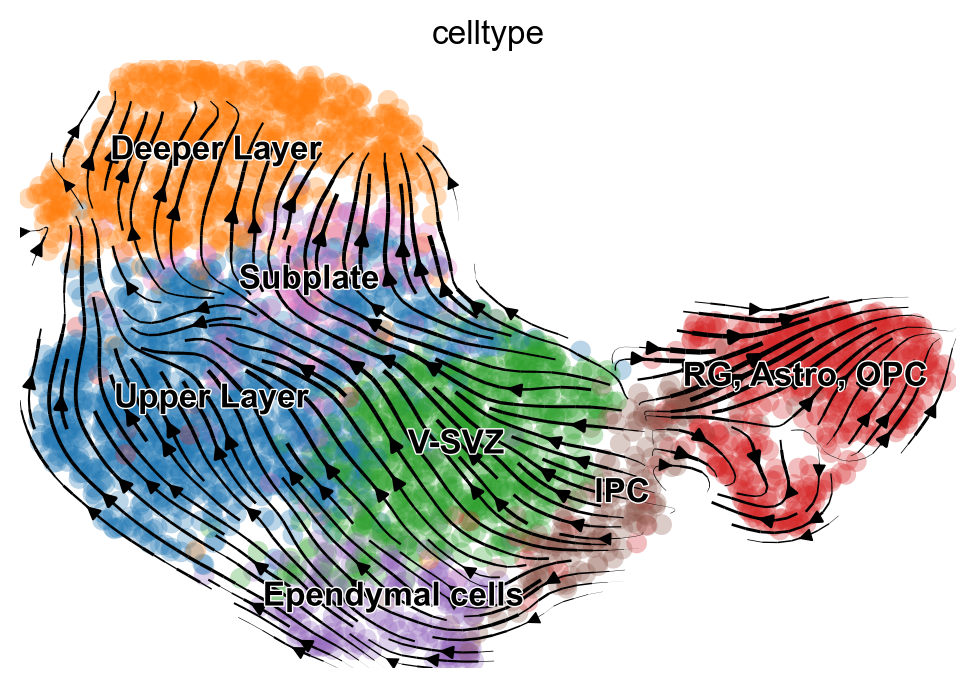

In [29]:
mv.velocity_embedding_stream(adata_result, basis='umap', color='celltype', show=True)

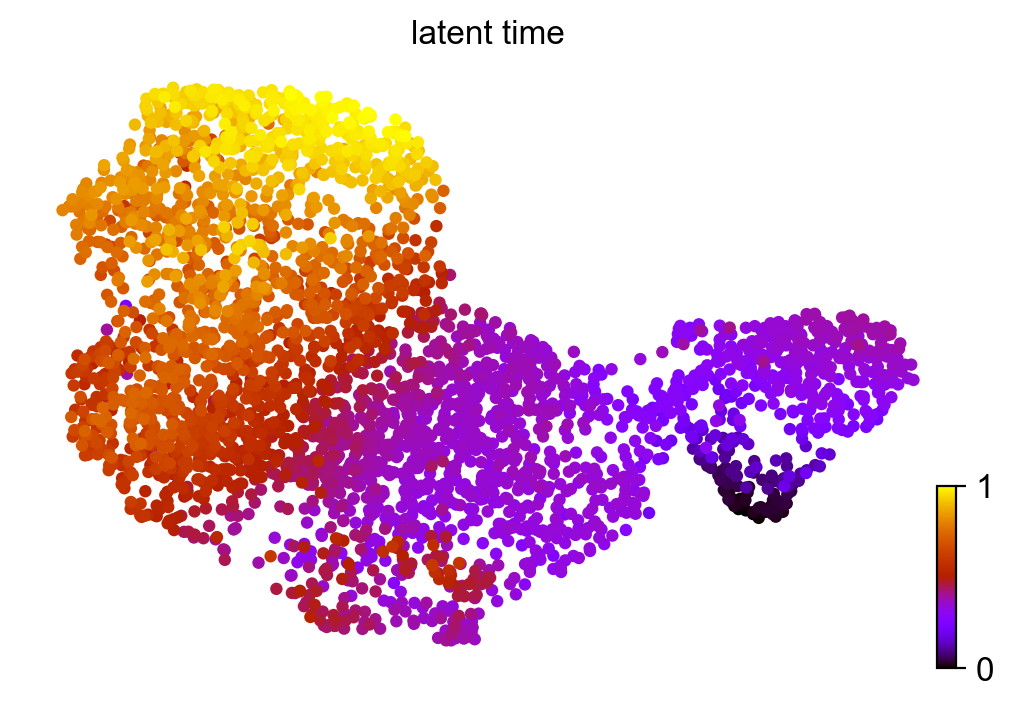

In [30]:
scv.pl.scatter(adata_result, color='latent_time', color_map='gnuplot', size=80)

## Fig 2b

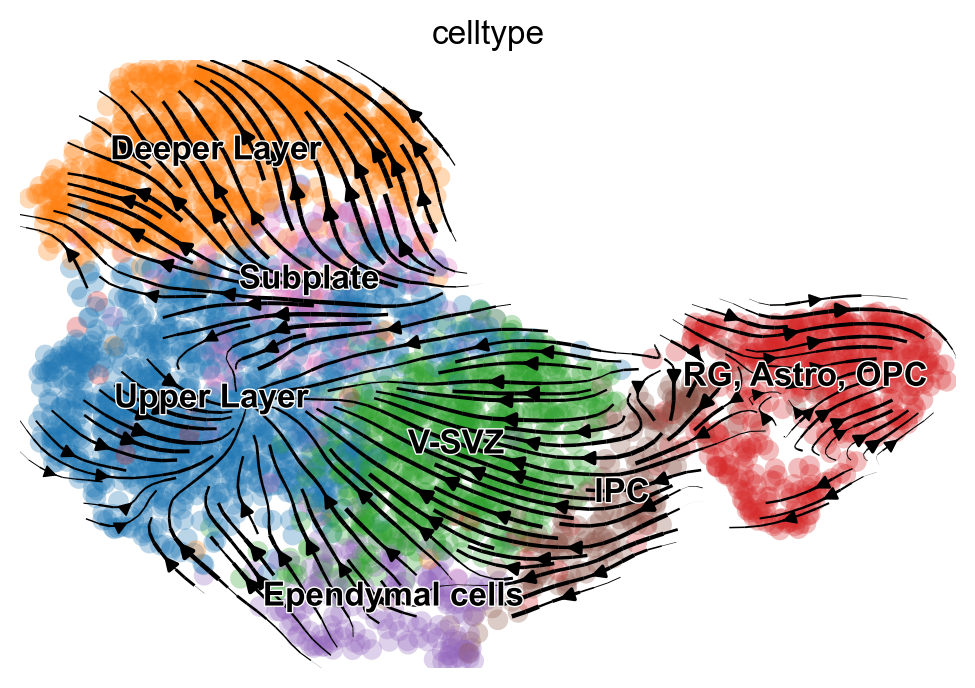

In [31]:
scv.pl.velocity_embedding_stream(adata_result, basis='umap', color='celltype')

## Fig 2c

calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


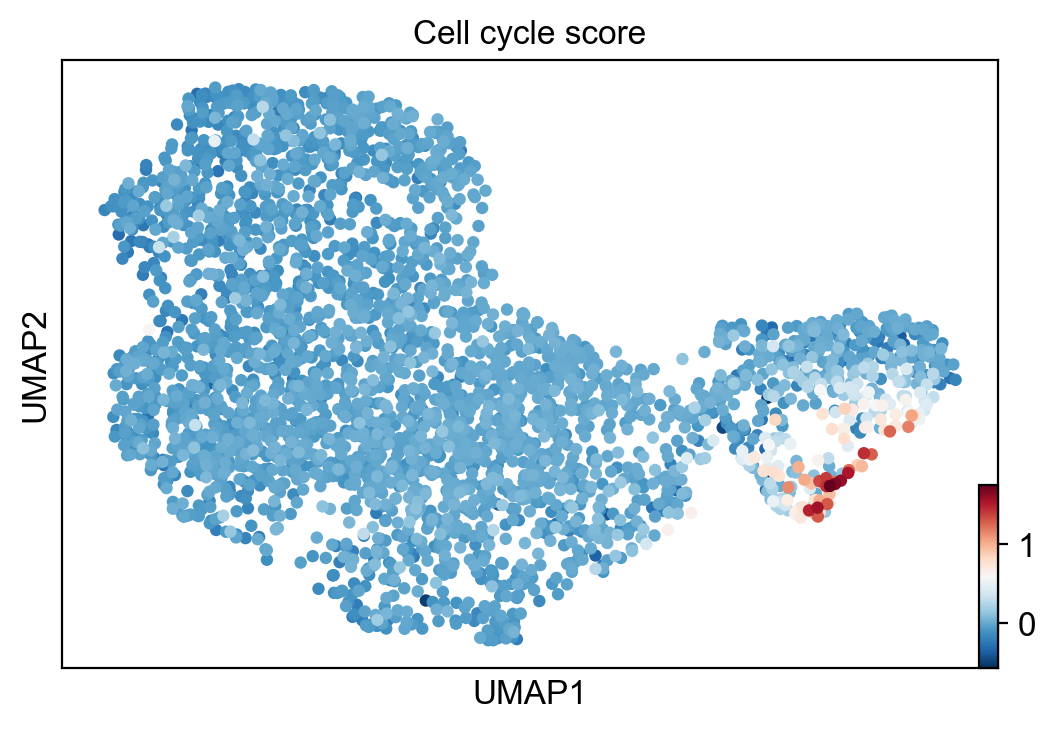

In [32]:
gcc_result = scv.tl.score_genes_cell_cycle(adata_result, copy=True)
scv.pl.scatter(gcc_result, color='G2M_score - S_score', size=80, frameon=True, title="Cell cycle score")

## Fig 2d

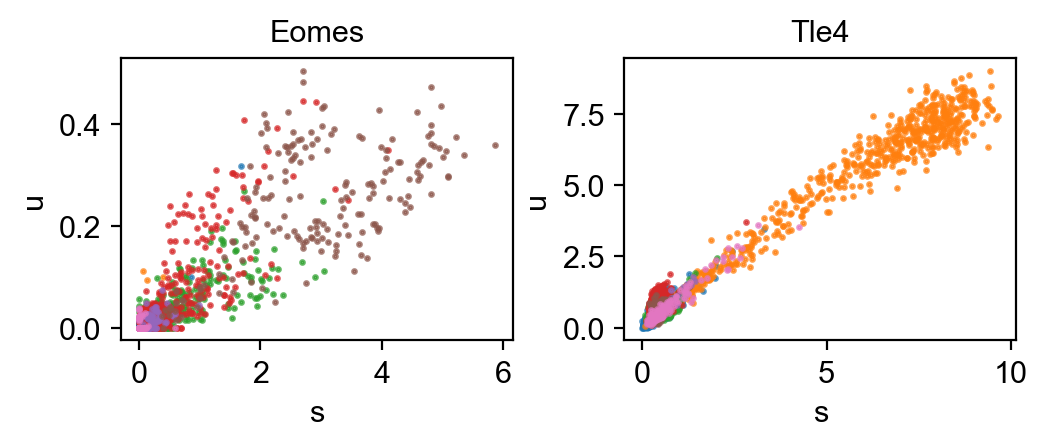

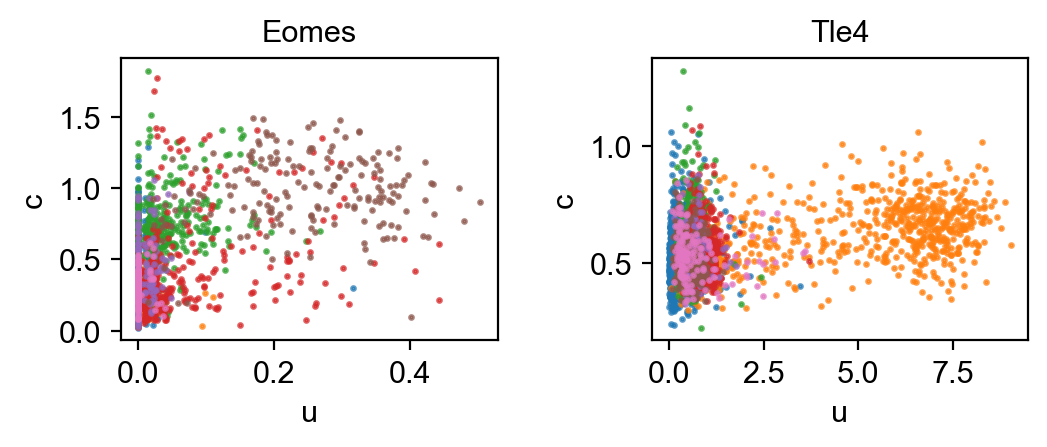

In [33]:
gene_list = ["Eomes", "Tle4"]
mv.scatter_plot(adata_result, by='us', show_anchors=False, color_by='celltype', genes=gene_list)
mv.scatter_plot(adata_result, by='cu', show_anchors=False, color_by='celltype', genes=gene_list)

## Fig 2e

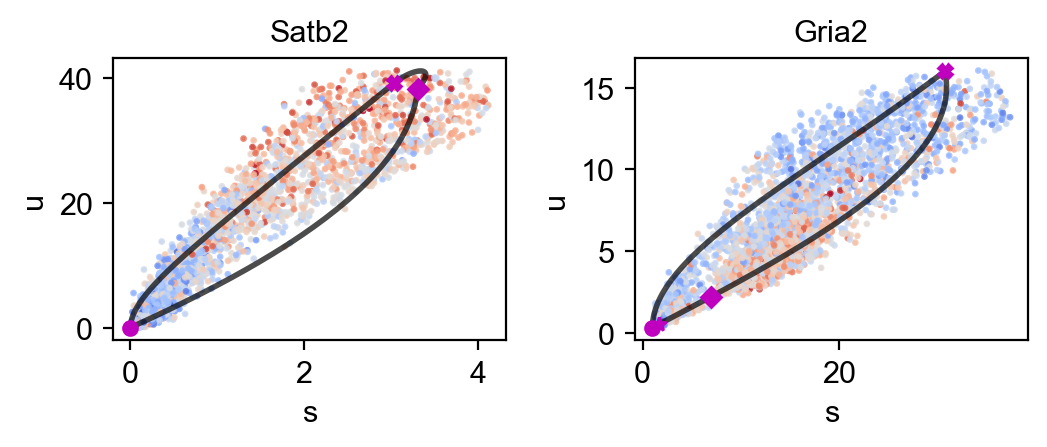

In [34]:
gene_list = ["Satb2", "Gria2"]
mv.scatter_plot(adata_result, color_by='c', genes=gene_list)

## Fig 2f

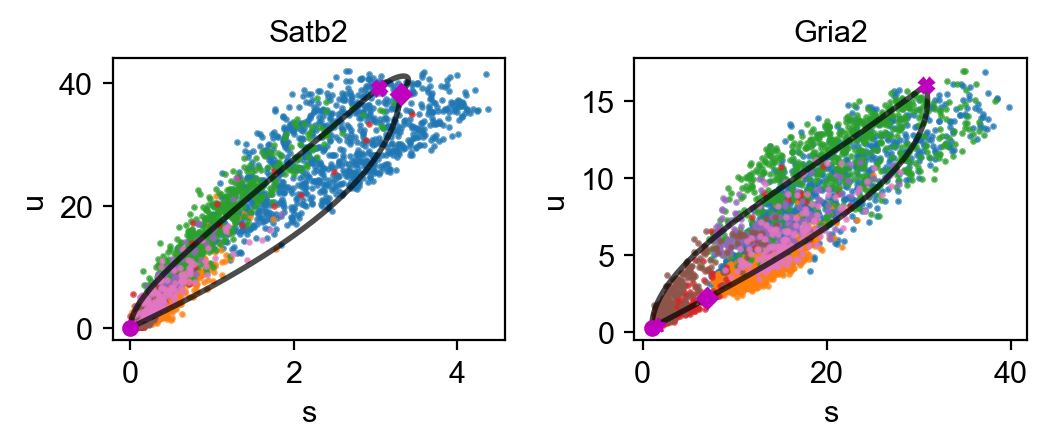

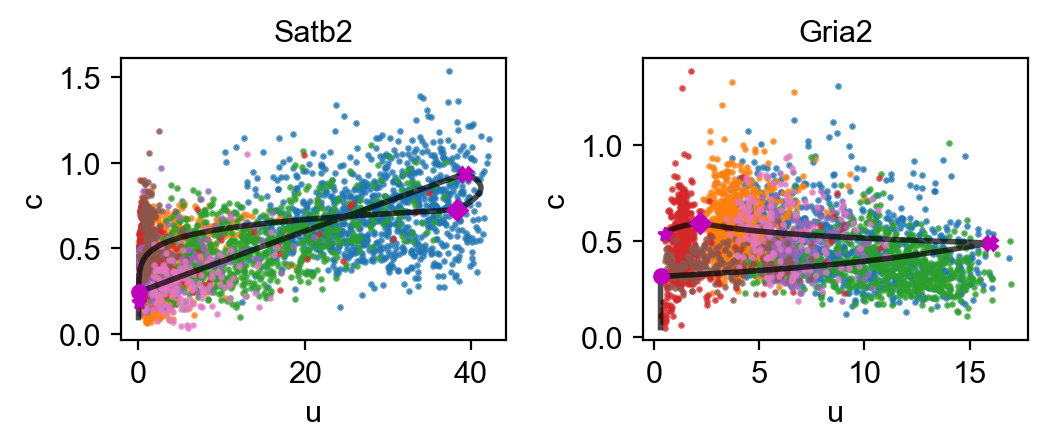

In [35]:
gene_list = ["Satb2", "Gria2"]
mv.scatter_plot(adata_result, by='us', color_by='celltype', genes=gene_list)
mv.scatter_plot(adata_result, by='cu', color_by='celltype', genes=gene_list)

## Fig 2g

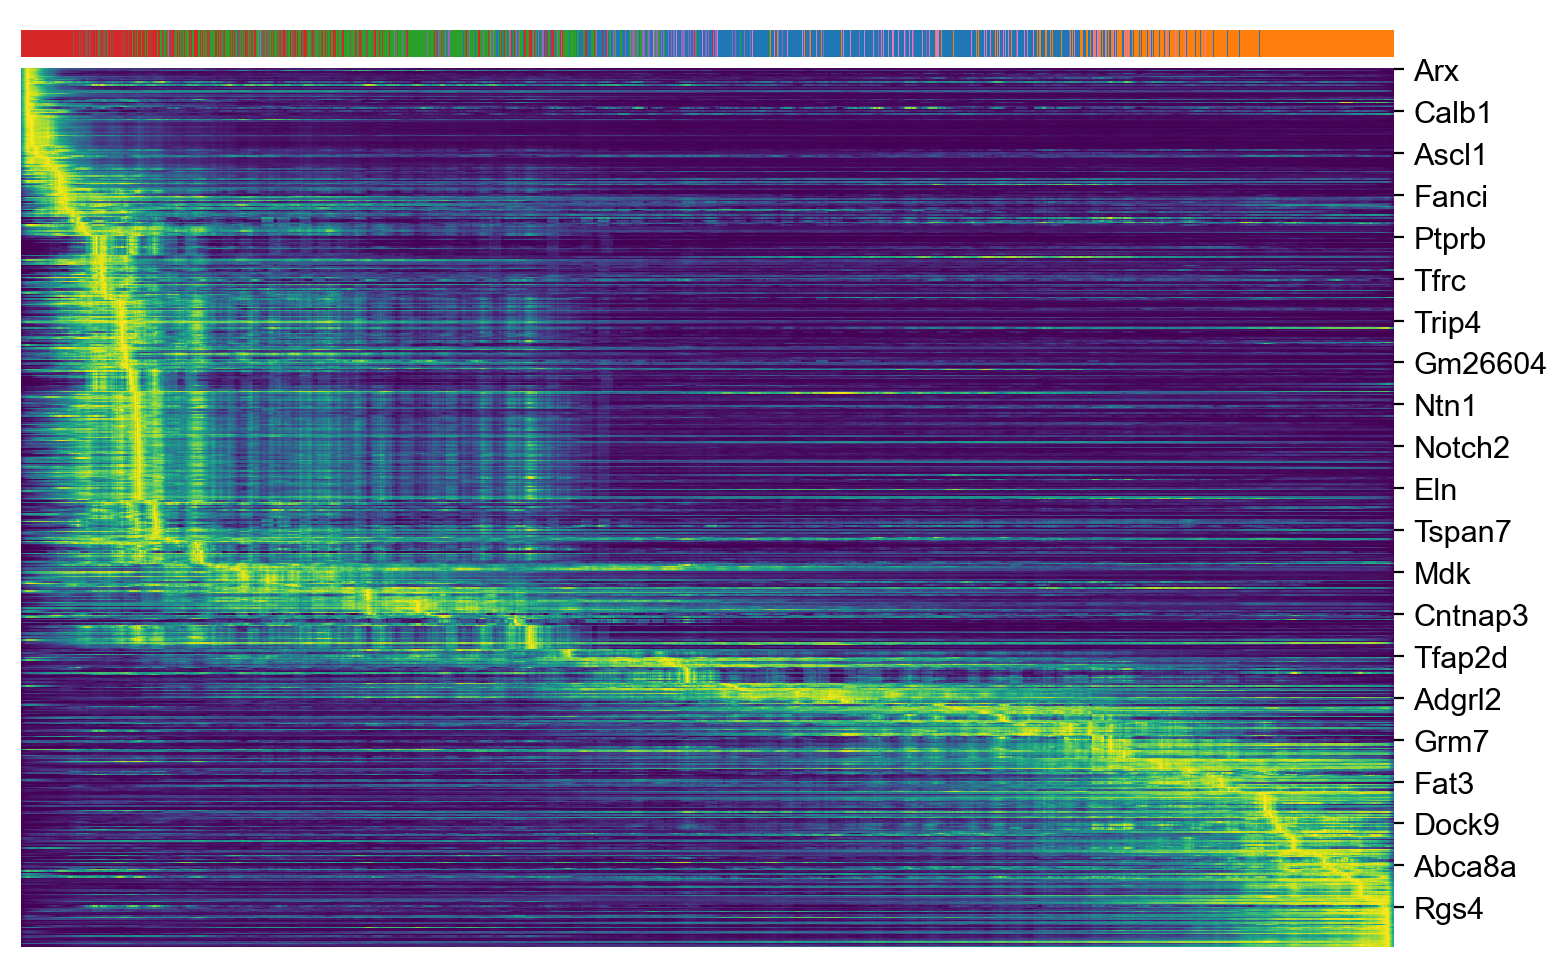

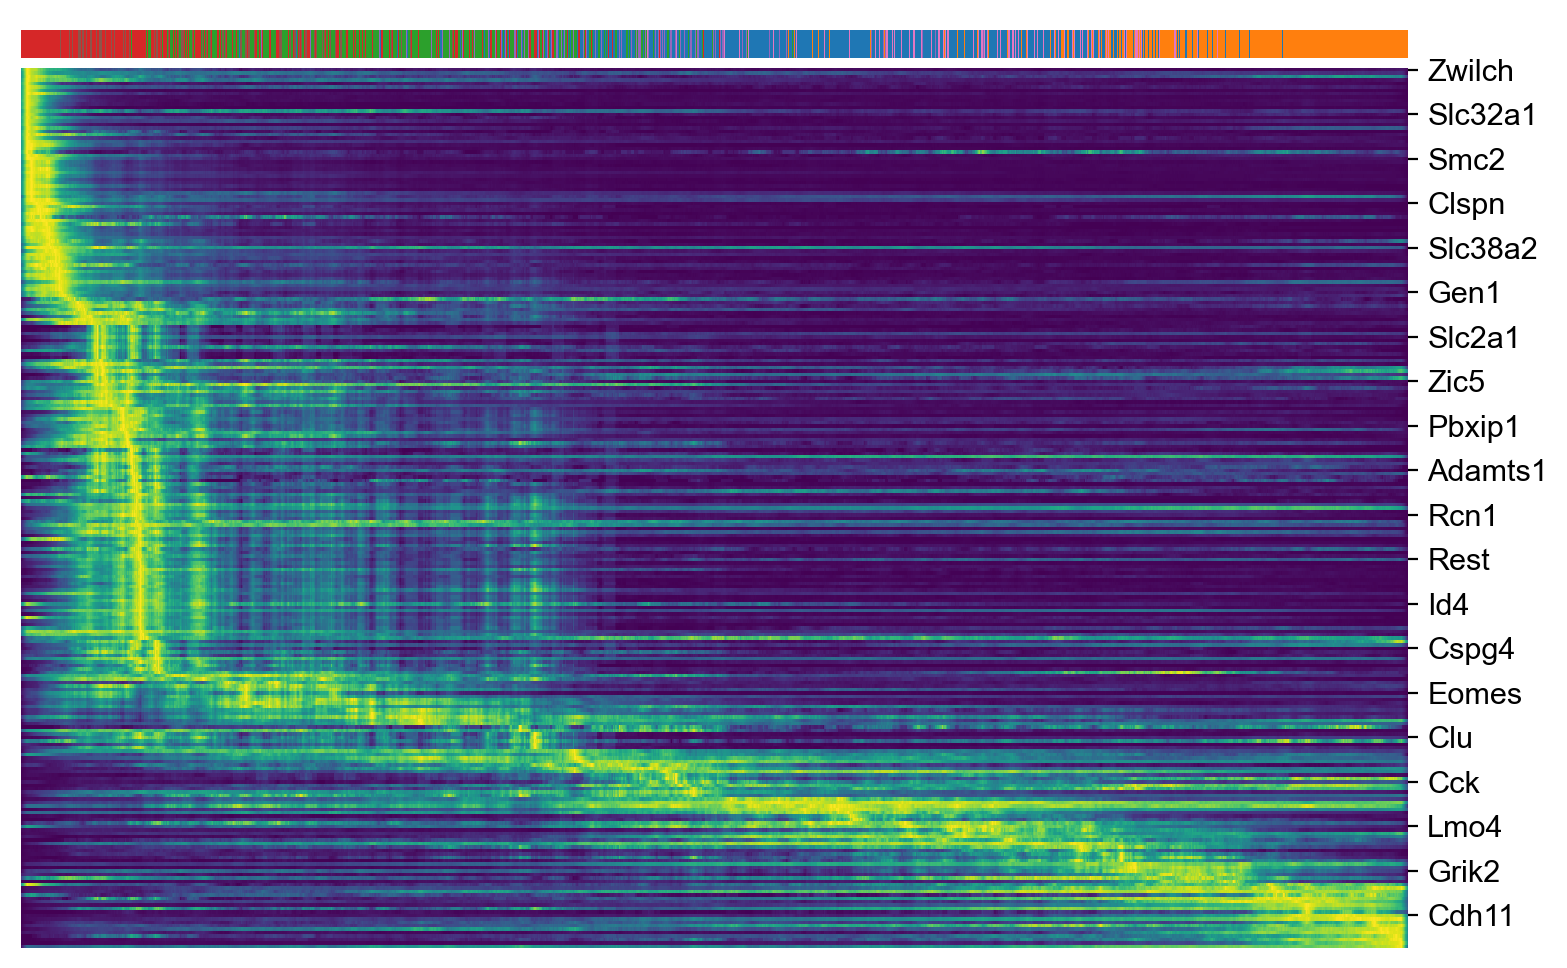

In [36]:
# get the model 1 genes
adata1 = adata_result[:, adata_result.var['fit_model'].values == 1]

# get the model 2 genes
adata2 = adata_result[:, adata_result.var['fit_model'].values == 2]

# heatmaps!
scv.pl.heatmap(adata1, var_names=adata1.var_names, col_color='celltype', figsize=(8, 5))
scv.pl.heatmap(adata2, var_names=adata2.var_names, col_color='celltype', figsize=(8, 5))

## Fig 2h

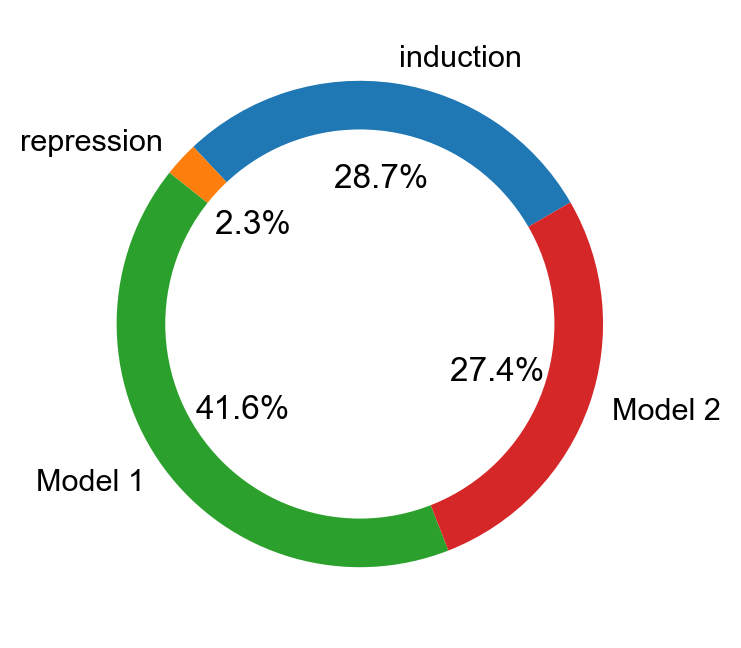

In [37]:
mv.pie_summary(adata_result)

## Fig 2i

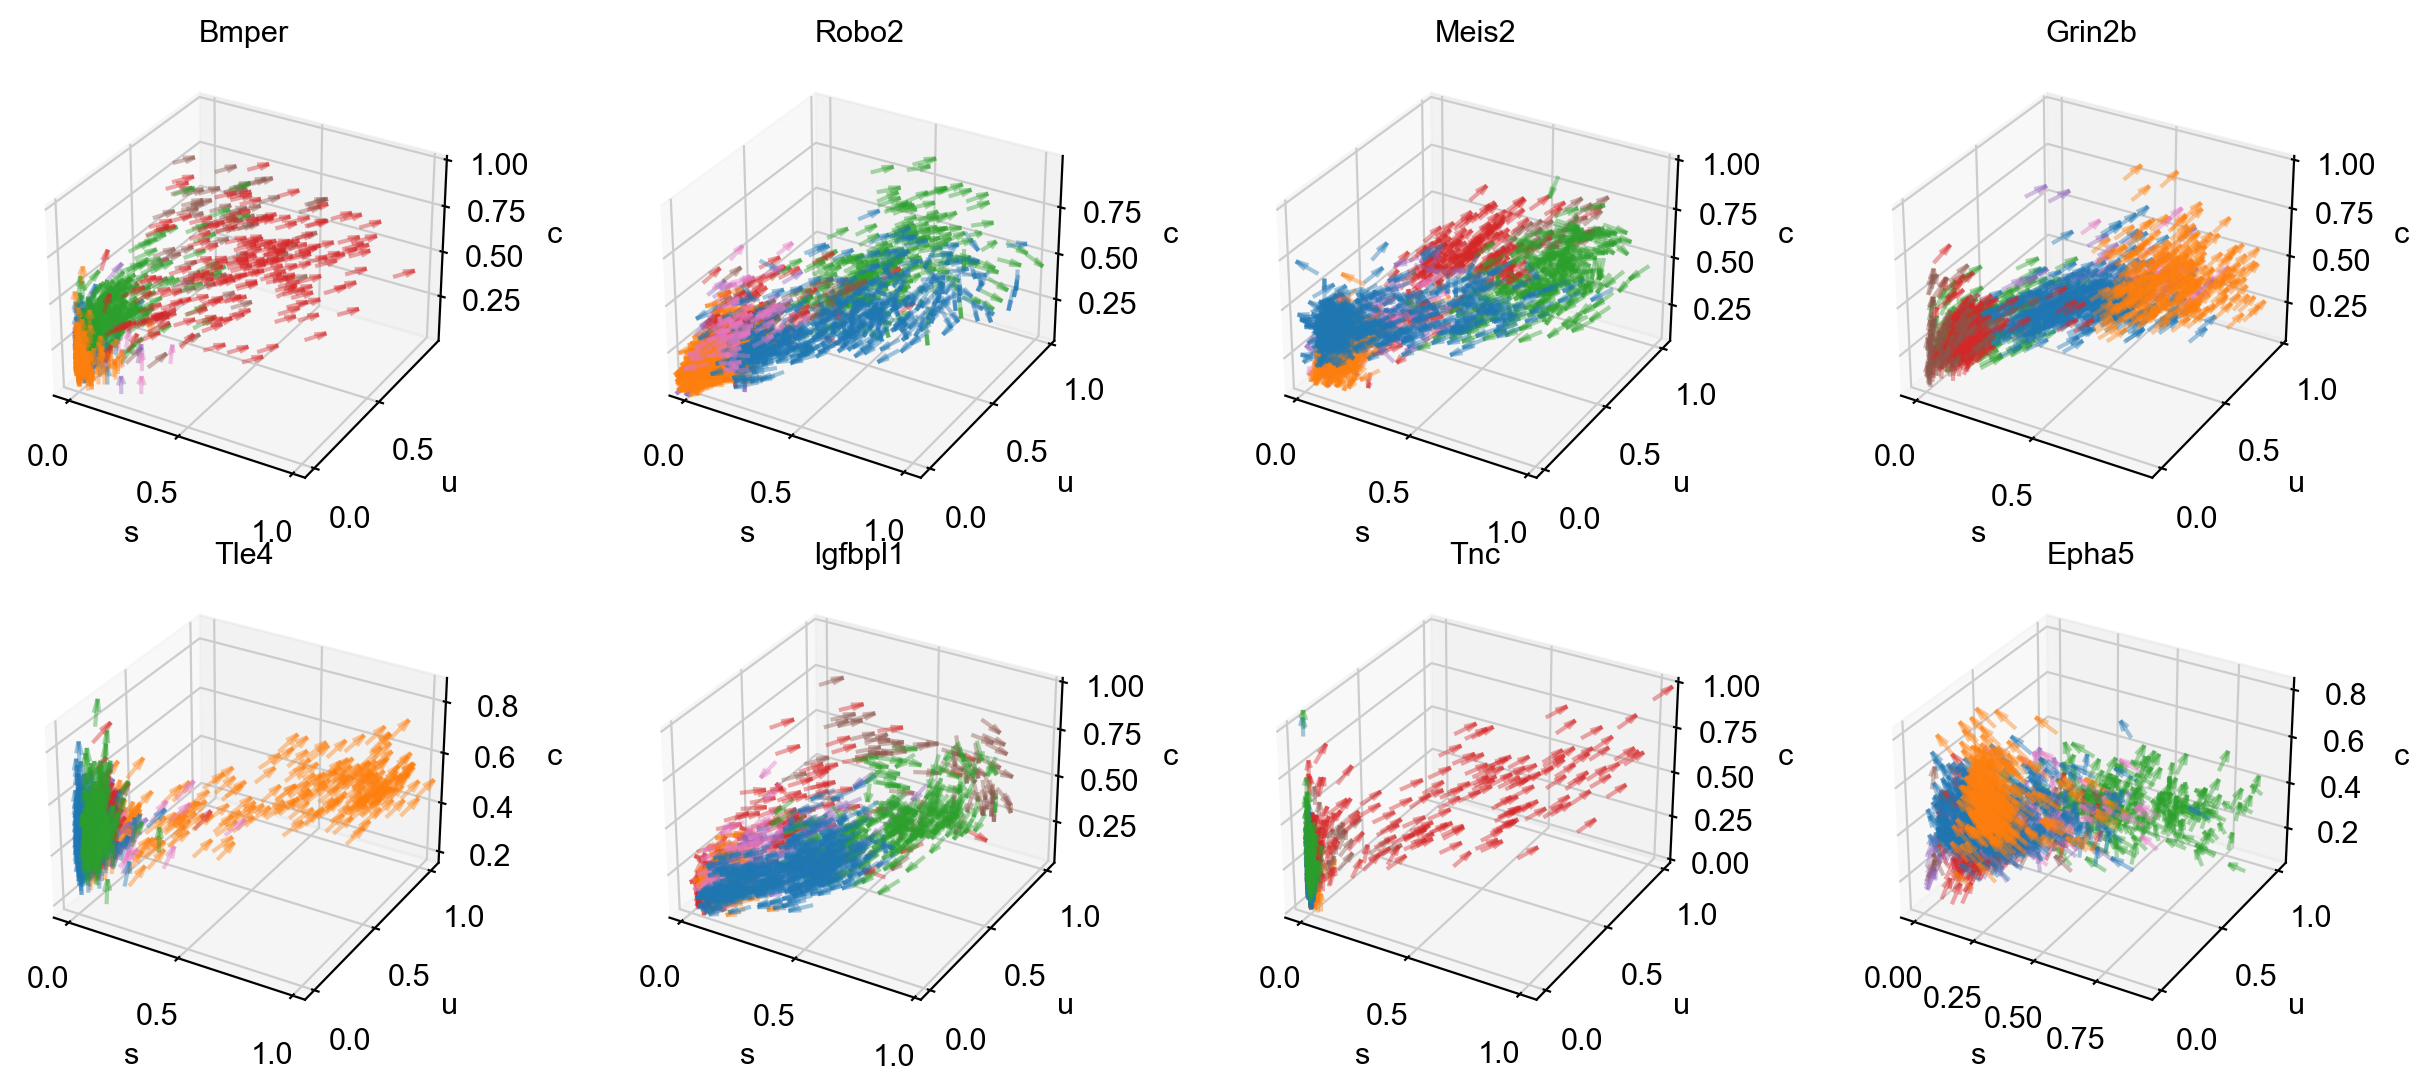

In [38]:
gene_list = ['Bmper', 'Robo2', 'Meis2', 'Grin2b', "Tle4", "Igfbpl1", "Tnc", "Epha5"]
mv.scatter_plot(adata_result, by='cus', n_cols=4, color_by='celltype', downsample=3, show_anchors=False, velocity_arrows=True, genes=gene_list)